# 4 - Funções Wiggly

<img src="./images/cat_bow_tie.jpg" atl="cat with bow tie" width=1000>

[](https://www.youtube.com/watch?v=ENxTrFf9a7c)

----

No capítulo anterior vimos como construir o nosso primeiro modelo de regressão linear, no qual estimamos a altura de uma pessoa usando a informação de seu próprio peso como um auxílio informativo. Temos, assim, como resultado do nosso modelo, a distribuição à posteriori dos parâmetros que foram estimados, $\alpha$, $\beta$ e o $\sigma$.

```{admonition} Modelo Linear Simples
$$ altura_i = \alpha + \beta (peso_i - peso\_médio)$$
```


Das distribuições à posteriori dos parâmetros podemos pegar apenas algum valor `"preciso"` desses parâmetros, ou seja, geralmente nós tendemos `pensar apenas com os valores esperados` (*`valores médios`*) da distribuição do $\alpha$ e do $\beta$ e, com isso, traçar uma linha reta com esses valores.

Olhando para os resultados das inferências dos parâmetros, quando o **peso** está em seu valor médio, temos que $\alpha$ significa o valor médio da altura! 

Percebeu? Percebeu como isso é muito bonito! Agora temos uma interpretação decente para o $\alpha$!

Agora, o que significa o nosso $\beta$? Temos que para cada unidade de $peso$ que aumentarmos a altura $h$ também aumentará em $\beta$ unidades. Assim, para nosso exemplo, `cada kilo que aumentarmos, a altura também tende a aumentar`, em média, $0.90$cm.



Mas sabemos que isso é insuficiente, porque queremos obter a incerteza a partir desse gráfico. A estatística bayesiana não lhe dará uma única estimativa pontual, mas sim, `dará a SUA incerteza, que é comunicada a nós pela distribuição à posteriori`. Essa incerteza é representada pelo *número infinito de linhas*, e cada uma dessas linhas são classificadas pela sua `plausibilidade relativa` (*sua probabilidade*) em comparação todas as outras linhas!

```{warning}
OBS: A partir de agora irei definir as variáveis em Inglês, mas os comentários continuarão em português para facilitar o entendimento seguir com o propósito do material. 

Em ambientes profissionais é recomendado escrever tudo em inglês.
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import nest_asyncio

In [2]:
import logging
logging.getLogger("pystan").propagate=False

In [3]:
# Desbloqueio do asyncIO do jupyter
nest_asyncio.apply()

In [4]:
# Definindo o plano de fundo cinza claro para todos os gráficos feitos no matplotlib
plt.rcParams['axes.facecolor'] = 'lightgray'

In [5]:
# Lendo os dados

# Os dados podem serem obtidos em https://github.com/rmcelreath/rethinking/tree/master/data/Howell1.csv
df = pd.read_csv('./data/Howell1.csv', sep=';')  

weight = df.loc[df.age >= 30, 'weight'].values  # Filtro para pessoas com 30 anos ou mais 
height = df.loc[df.age >= 30, 'height'].values  # Filtro para pessoas com 30 anos ou mais

In [6]:
model_stan = """
    data {
        int N;
        vector[N] height;
        vector[N] weight;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0, upper=50> sigma;  // Priori implícita Uniforme(0, 50)
    }
    
    model {
        alpha ~ normal(178, 20);  // Priori para Alpha
        beta ~ lognormal(0, 1);  // Priori para Beta
        
        height ~ normal(alpha + beta * weight, sigma);
    }
"""

In [7]:
# =============================================================
#    Estimativa da altura explicada com a variável peso.
# =============================================================
# Reescrevendo o modelo anterior 

# Lembrando que estamos usando o (x_i - x_barra) e não apenas x_i
weight_adjust = weight - weight.mean() 

my_data = {
    'N': len(weight),
    'height': height,
    'weight': weight_adjust,
}

posteriori = stan.build(model_stan, data=my_data)
fit = posteriori.sample(num_chains=4, num_samples=1000)

# Recuperando os parâmetros
alpha = fit['alpha'].flatten()
beta = fit['beta'].flatten()
sigma = fit['sigma'].flatten()


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_56faqn6p/model_66wsz7lg.stan', line 16, column 8: Parameter
    beta is given a lognormal distribution, which has strictly positive
    support, but beta was not constrained to be strictly positive.
Warning in '/tmp/httpstan_56faqn6p/model_66wsz7lg.stan', line 15, column 28: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_56faqn6p/model_66wsz7lg.stan', line 15, column 23: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient indu

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -4.4448, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.276438, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66ws

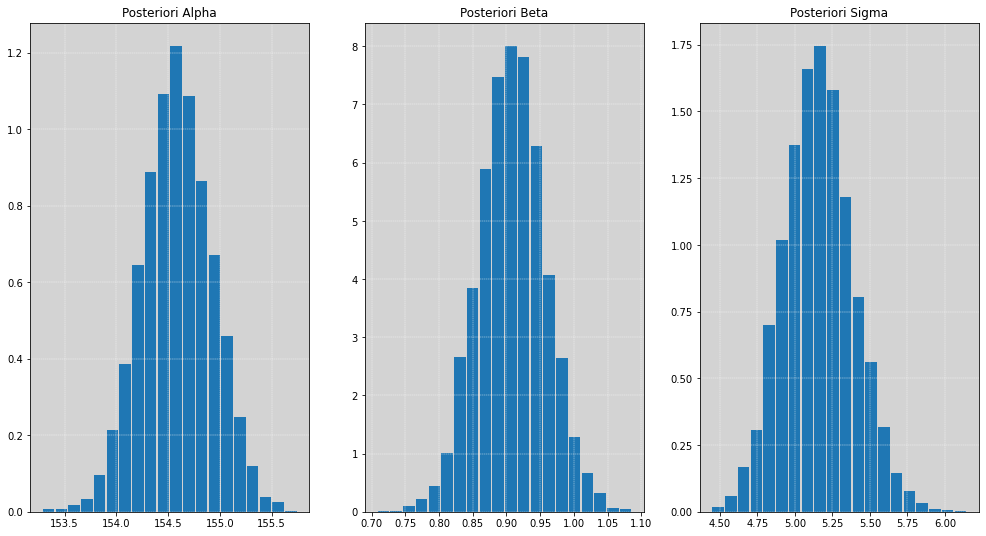

In [8]:
# ==========================================
#  Plotando os histogramas dos Parâmentros
# ==========================================

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(17, 9))

# Parâmetro: alpha
ax1.hist(alpha, density=True, rwidth=0.9, bins=20)
ax1.grid(ls='--', color='white', linewidth=0.4)
ax1.set_title('Posteriori Alpha')

# Parâmetro: beta
ax2.hist(beta, density=True, rwidth=0.9, bins=20)
ax2.grid(ls='--', color='white', linewidth=0.4)
ax2.set_title('Posteriori Beta')

# Parâmetro: sigma
ax3.hist(sigma, density=True, rwidth=0.9, bins=20)
ax3.grid(ls='--', color='white', linewidth=0.4)
ax3.set_title('Posteriori Sigma')

plt.show()

## A observação da nossa Incerteza

Agora nós iremos fazer a amostragem das *posterioris*. Uma das razões para usarmos esse procedimento de amostragem é que isso torna mais fácil de se pensar e, também, esse procedimento pode ser aplicado a **todos** os tipos de modelos possíveis bayesianos que quisermos ajustar.

Nossa distribuição à posteriori contém muitas linhas retas lá dentro, representadas pela amostragem dos valores da distribuição dos $\alpha$ e dos $\beta$ com o $\sigma$ informando o desvio padrão.

Abaixo vamos ver as primeiras linhas do conjunto de dados dessas estimativas e as suas medidas de resumo:

In [9]:
print(pd.DataFrame({'alpha': alpha[:10], 'beta': beta[:10], 'sigma': sigma[:10]}))

        alpha      beta     sigma
0  154.546096  0.990010  5.183055
1  154.630627  0.919571  5.522559
2  154.297672  0.880644  5.117238
3  153.970984  0.905280  5.245877
4  154.415319  1.012177  5.186475
5  155.220709  0.828843  5.590288
6  154.610061  0.833036  5.068043
7  154.297318  1.017654  5.213467
8  154.686280  1.026647  5.156311
9  154.862340  0.929668  5.102898


```{note}
Para cada linha do conjunto de dados acima é uma linha reta no nosso modelo! 
```

e o resumo dos dados:

In [10]:
pd.DataFrame({'alpha': alpha[:10], 'beta': beta[:10], 'sigma': sigma[:10]}).describe()

alpha       beta      sigma
count   10.000000  10.000000  10.000000
mean   154.553741   0.934353   5.238621
std      0.342682   0.074520   0.176323
min    153.970984   0.828843   5.068043
25%    154.327084   0.886803   5.127006
50%    154.578078   0.924620   5.184765
75%    154.672367   1.006635   5.237774
max    155.220709   1.026647   5.590288

Nós temos muitas linhas! E as linhas `mais plausíveis são as linhas que tem maior número de maneiras de reproduzir os dados que observamos`. Essa plausabilidade é apresentada para nós através do maior acúmulo de linhas retas que se sobrepõem. 


Quanto mais as linhas se sobreporem entre si em uma certa região, `maior será a plausabilidade dessas retas descreverem os dados que observamos`. 


```{note}
`O acúmulo dessas retas representa a nossa incerteza.`
```

Foi primeira vez que conseguimos realmente observar, conscientemente, a nossa incerteza em um gráfico. *Lindo demais*!!!

Para termos uma melhor compreensão nesse momento, nós vamos supor que ao invés de nossa amostra ter 251 indivíduos, vamos supor que temos apenas alguns subconjuntos. Nosso objetivo aqui é mostrar que quanto mais informações temos (isto é, quanto *maior a nossa amostra*), menor será a nossa incerteza!

Para ficar mais claro, vamos simular a essa nossa estratégia e ver as diferenças dos **acúmulos das linhas**.

In [11]:
def generate_parcial_stan_models_results(N):
    """
    Ajustando as estimativas de um modelo linear 
    usando os primeiros N indivíduos da amostra.
    
    Parameters:
        N: Quantidade de indivíduos que iremos 
           utilizar na estimativa dos parâmetros.
    
    Return: 
       Estimativas do alpha, beta e o sigma, dado os dados. 
    """
    weight_adjust = weight - weight.mean() 

    my_data = {
        'N': N,
        'height': height[:N],
        'weight': weight_adjust[:N],
    }

    posteriori = stan.build(model_stan, data=my_data)
    fit = posteriori.sample(num_chains=4, num_samples=1000)

    # Recuperando os parâmetros
    alpha = fit['alpha'].flatten()
    beta = fit['beta'].flatten()
    sigma = fit['sigma'].flatten()
    
    return alpha, beta, sigma

In [12]:
# =====================================================
#   Rodando o modelo anterior utilizando diferentes N
# =====================================================

N_10 = 10     
alpha_10, beta_10, sigma_10 = generate_parcial_stan_models_results(N_10);


N_50 = 50     
alpha_50, beta_50, sigma_50 = generate_parcial_stan_models_results(N_50);


N_100 = 100     
alpha_100, beta_100, sigma_100 = generate_parcial_stan_models_results(N_100);


N = len(weight) # Com toda amostra disponível
alpha, beta, sigma = generate_parcial_stan_models_results(N);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_56faqn6p/model_66wsz7lg.stan', line 16, column 8: Parameter
    beta is given a lognormal distribution, which has strictly positive
    support, but beta was not constrained to be strictly positive.
Warning in '/tmp/httpstan_56faqn6p/model_66wsz7lg.stan', line 15, column 28: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_56faqn6p/model_66wsz7lg.stan', line 15, column 23: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient indu

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.360246, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -44.3743, but must be nonnegative! (in '/tm

  Exception: lognormal_lpdf: Random variable is -36.6047, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.401514, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.0446323, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.00212482, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types lik

  Exception: lognormal_lpdf: Random variable is -45.3429, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.16722, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.143145, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.206063, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be eit

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -48.662, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exceptio

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.21922, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.58251, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like cov

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -123.423, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -4.51816, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be eithe

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -4.06661, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.111333, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like co

  Exception: lognormal_lpdf: Random variable is -0.146024, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.286707, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about t

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.3752, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.89216, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.98668, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.0931483, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.0262864, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like

  Exception: lognormal_lpdf: Random variable is -243.969, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -4.04061, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.155042, but must be nonnegative! (in '/tmp/httpstan_guqnxlg4/model_66wsz7lg.stan', line 16, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


```{note}
Uma das vantagens do gráfico gráfico de linhas (gráfico de espaguetes) é deixar claro que os limites formados pelas retas não tem significado algum.
```

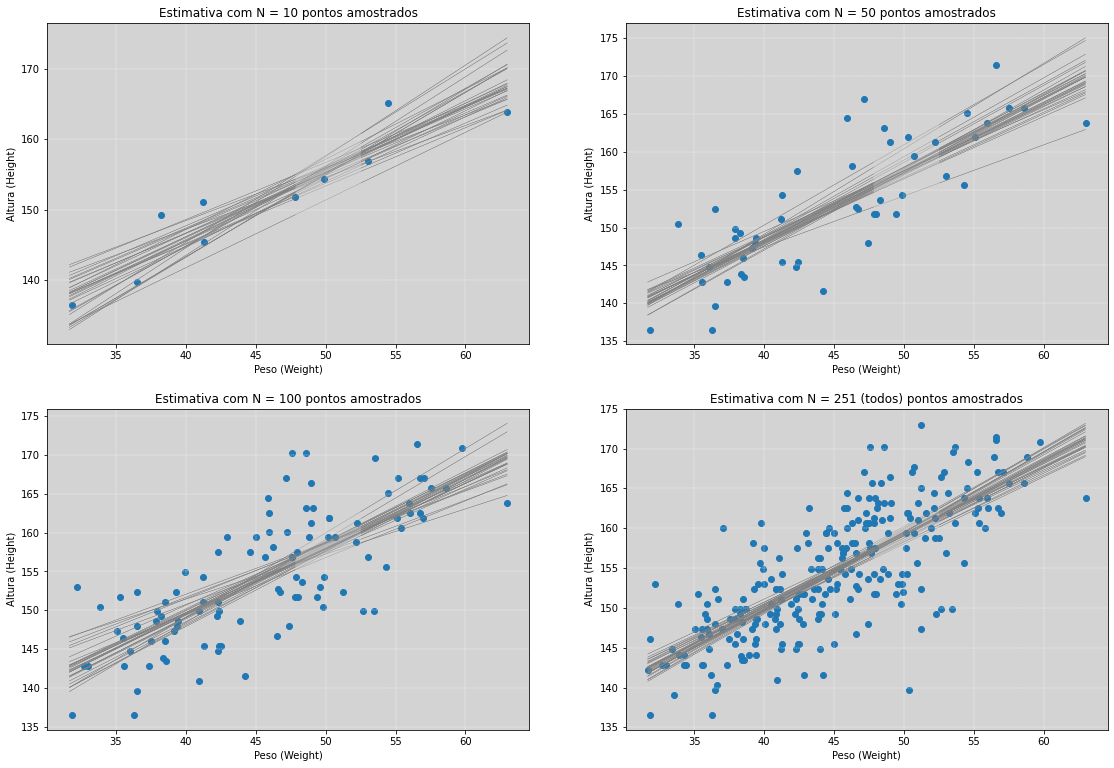

In [13]:
# =============================
#     Gráfico de Espaguete
# =============================
# Vamos usar a variável weight_adjust igual para todos os 
# pesos sem perda de generalidade para essa análise.

# Plot dos dados altura x peso
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(19, 13))

# Número de linhas retas que iremos plotar
qty_lines = 30

# ===============================================
#    Estimando as curvas usando 10 amostras
# ===============================================

ax1.scatter(weight[:N_10], height[:N_10])

for i in range(qty_lines):
    ax1.plot(weight, alpha_10[i] + beta_10[i] * weight_adjust, color='gray', linewidth=0.3)

ax1.grid(ls='--', color='white', linewidth=0.4)
ax1.set_title('Estimativa com N = ' + str(N_10) + ' pontos amostrados')
ax1.set_xlabel('Peso (Weight)')
ax1.set_ylabel('Altura (Height)')


# ===============================================
#    Estimando as curvas usando 50 amostras
# ===============================================

ax2.scatter(weight[:N_50], height[:N_50])

for i in range(qty_lines):
    ax2.plot(weight, alpha_50[i] + beta_50[i] * weight_adjust, color='gray', linewidth=0.3)

ax2.grid(ls='--', color='white', linewidth=0.4)
ax2.set_title('Estimativa com N = ' + str(N_50) + ' pontos amostrados')
ax2.set_xlabel('Peso (Weight)')
ax2.set_ylabel('Altura (Height)')


# ===============================================
#    Estimando as curvas usando 100 amostras
# ===============================================

ax3.scatter(weight[:N_100], height[:N_100])

for i in range(qty_lines):
    ax3.plot(weight, alpha_100[i] + beta_100[i] * weight_adjust, color='gray', linewidth=0.3)

ax3.grid(ls='--', color='white', linewidth=0.4)
ax3.set_title('Estimativa com N = ' + str(N_100) + ' pontos amostrados')
ax3.set_xlabel('Peso (Weight)')
ax3.set_ylabel('Altura (Height)')


# =================================================
#    Estimando as curvas usando todas as amostras
# =================================================

ax4.scatter(weight, height)

for i in range(qty_lines):
    ax4.plot(weight, alpha[i] + beta[i] * weight_adjust, color='gray', linewidth=0.3)

ax4.grid(ls='--', color='white', linewidth=0.4)
ax4.set_title('Estimativa com N = ' + str(N) + ' (todos) pontos amostrados')
ax4.set_xlabel('Peso (Weight)')
ax4.set_ylabel('Altura (Height)')

plt.show()

A divisão dos gráficos acima foi construída para conseguirmos percerber, de modo visual, `que quando mais amostras tivermos coletado` (isto é, *quanto maior número de pontos azuis nós tivermos coletados como amostra*), mais informações teremos e, portanto, teremos muito `menos incerteza` sobre o nosso objeto de estudo. 

A nossa incerteza pode ser observada pela *dispersão* das curvas no gráfico, portanto `quanto maior for a dispersão maior será a nossa incerteza` sobre o que está acontecendo.

## Construindo a Distribuição Preditiva de $\mu_i$, dado um peso $x_i$

Modelo linear para a altura média $\mu_i$ é: 


$$ \mu_i = \alpha + \beta(x_i - \bar{x}) $$

Agora, a ideia básica é que, dado um valor específico do peso de um indivíduo, $x_i$ (*weight*), podemos obter uma distribuição preditiva do $\mu_i$. Essa distribuição preditiva nos informa quais as regiões de maior confiança que podemos esperar para a média da altura, de uma pessoa com o peso $x_i$.

Para exemplificar, vamos supor que queremos estimar a altura (*height*) de uma pessoa com $50 kg$, então:

$$ \mu_i = \alpha + \beta(50 - \bar{x}) $$

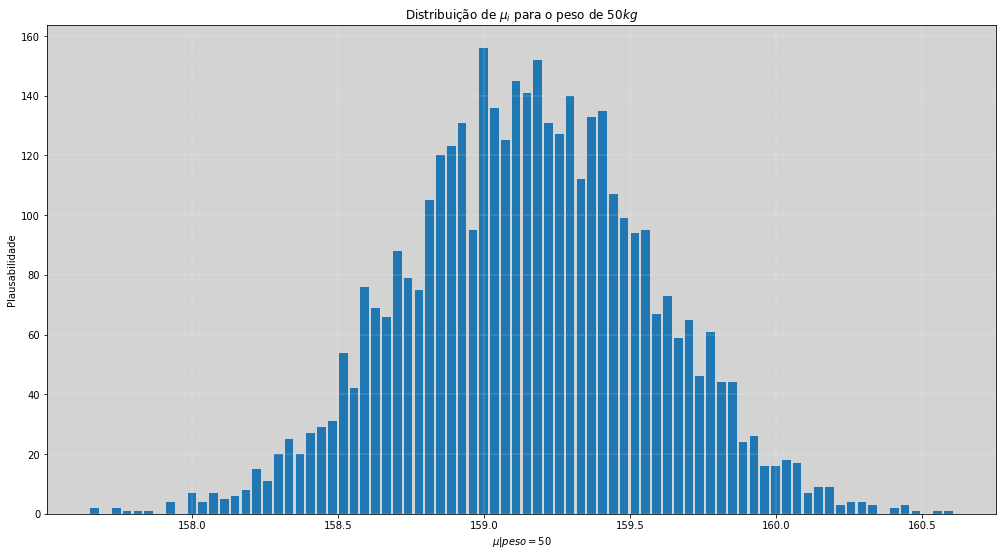

In [14]:
# ===========================================================
#    Construindo a distribuição preditiva de 𝜇 | x=50
# ===========================================================

mu_50_kg = alpha + beta * (50 - weight.mean())

plt.figure(figsize=(17, 9))
plt.hist(mu_50_kg, density=False, bins=80, rwidth=0.8)
plt.grid(ls='--', color='white', linewidth=0.3)

plt.title('Distribuição de $\mu_i$ para o peso de $50 kg$')
plt.ylabel('Plausabilidade')
plt.xlabel('$\mu | peso=50$')

plt.show()

## Calculando a predição para todos os $\mu_i$

In [15]:
def HPDI(posterior_samples, credible_mass):
    
    # Calcula o maior intervalo de probabilidades a partir de uma amostra
    
    # Fonte: https://stackoverflow.com/questions/22284502/highest-posterior-density-region-and-central-credible-region
    # ** Refazer essa função para entender **
    
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
        HDImin = sorted_points[ciWidth.index(min(ciWidth))]
        HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]

    return(HDImin, HDImax)

In [16]:
# =====================================
#    Calculando o HPDI dos dados
# =====================================

posterioris_dict_10 = {}  # Dicionário com todas as posterioris para cada um dos pesos (weight) variando de 25 á 70.
posterioris_dict_50 = {}  # Dicionário com todas as posterioris para cada um dos pesos (weight) variando de 25 á 70.
posterioris_dict_100 = {}  # Dicionário com todas as posterioris para cada um dos pesos (weight) variando de 25 á 70.
posterioris_dict = {}  # Dicionário com todas as posterioris para cada um dos pesos (weight) variando de 25 á 70.

for weight_i in range(25, 71):
    posterioris_dict_10[weight_i] = alpha_10 + beta_10 * (weight_i - weight.mean())
    posterioris_dict_50[weight_i] = alpha_50 + beta_50 * (weight_i - weight.mean())
    posterioris_dict_100[weight_i] = alpha_100 + beta_100 * (weight_i - weight.mean())
    posterioris_dict[weight_i] = alpha + beta * (weight_i - weight.mean())
    
# Gerando os dataframes
posterioris_10 = pd.DataFrame(posterioris_dict_10)
posterioris_50 = pd.DataFrame(posterioris_dict_50)
posterioris_100 = pd.DataFrame(posterioris_dict_100)
posterioris = pd.DataFrame(posterioris_dict)

# Calculando as médias das posterioris
posterioris_means_10 = posterioris_10.mean()
posterioris_means_50 = posterioris_50.mean()
posterioris_means_100 = posterioris_100.mean()
posterioris_means = posterioris.mean()

# Calculando os intervalos de HPDI das posterioris
posterioris_HPDIs_10 = []
posterioris_HPDIs_50 = []
posterioris_HPDIs_100 = []
posterioris_HPDIs = []

for weight_i in range(25, 71):
    posterioris_HPDIs_10.append(HPDI(posterioris_10[weight_i], 0.89))
    posterioris_HPDIs_50.append(HPDI(posterioris_50[weight_i], 0.89))
    posterioris_HPDIs_100.append(HPDI(posterioris_100[weight_i], 0.89))
    posterioris_HPDIs.append(HPDI(posterioris[weight_i], 0.89))
    
# Tranformando os dados em um array numpy    
posterioris_HPDIs_10 = np.array(posterioris_HPDIs_10)  
posterioris_HPDIs_50 = np.array(posterioris_HPDIs_50) 
posterioris_HPDIs_100 = np.array(posterioris_HPDIs_100)
posterioris_HPDIs = np.array(posterioris_HPDIs)

### A Compatibilidade da Gravata Borboleta

Conforme os quatro gráficos plotados acima, iremos replotá-los porém agora mostrando o `intervalo de compatibilidade` (*estilo gravata borboleta*). 


<img src="./images/bow_tie.jpg" alt="Bow Tie" width=1000>

Ao olhar para esse gráfico é fácil cairmos na tentação de acharmos que os limites que escolhemos significa alguma coisa, `ele não tem nenhum significado` a não ser os limites de corte pelo HPDI que escolhemos. 

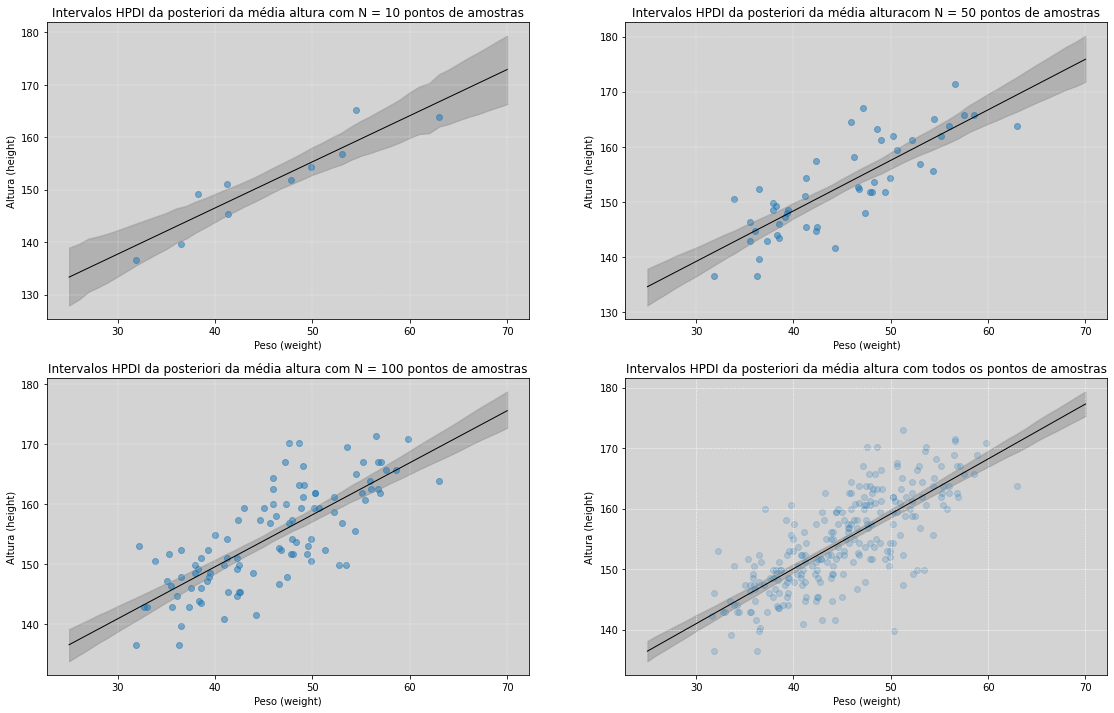

In [17]:
# ==================================================
#       Plotando os gráfico de gravata borboletas
# ==================================================

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(19,12))

# ===============================================
#    Estimando as curvas usando 10 amostras
# ===============================================
ax1.plot(range(25, 71), posterioris_HPDIs_10, color='darkgray', linewidth=0.5)
ax1.fill_between(range(25, 71), posterioris_HPDIs_10[:, 0], posterioris_HPDIs_10[:, 1], color='gray', alpha=0.4)
ax1.scatter(weight[:N_10], height[:N_10], alpha=0.5)

ax1.plot(range(25, 71), posterioris_means_10, color='black', linewidth=1)
ax1.grid(ls='--', color='white', linewidth=0.3)
ax1.set_title('Intervalos HPDI da posteriori da média altura com N = ' + str(N_10) + ' pontos de amostras')
ax1.set_ylabel('Altura (height)')
ax1.set_xlabel('Peso (weight)')

# ===============================================
#    Estimando as curvas usando 50 amostras
# ===============================================
ax2.plot(range(25, 71), posterioris_HPDIs_50, color='darkgray', linewidth=0.5)
ax2.fill_between(range(25, 71), posterioris_HPDIs_50[:, 0], posterioris_HPDIs_50[:, 1], color='gray', alpha=0.4)
ax2.scatter(weight[:N_50], height[:N_50], alpha=0.5)

ax2.plot(range(25, 71), posterioris_means_50, color='black', linewidth=1)
ax2.grid(ls='--', color='white', linewidth=0.3)
ax2.set_title('Intervalos HPDI da posteriori da média alturacom N = ' + str(N_50) + ' pontos de amostras')
ax2.set_ylabel('Altura (height)')
ax2.set_xlabel('Peso (weight)')

# ===============================================
#    Estimando as curvas usando 100 amostras
# ===============================================
ax3.plot(range(25, 71), posterioris_HPDIs_100, color='darkgray', linewidth=0.5)
ax3.fill_between(range(25, 71), posterioris_HPDIs_100[:, 0], posterioris_HPDIs_100[:, 1], color='gray', alpha=0.4)
ax3.scatter(weight[:N_100], height[:N_100], alpha=0.5)

ax3.plot(range(25, 71), posterioris_means_100, color='black', linewidth=1)
ax3.grid(ls='--', color='white', linewidth=0.3)
ax3.set_title('Intervalos HPDI da posteriori da média altura com N = ' + str(N_100) + ' pontos de amostras')
ax3.set_ylabel('Altura (height)')
ax3.set_xlabel('Peso (weight)')

# ==================================================
#    Estimando as curvas usando todas as amostras
# ==================================================
ax4.plot(range(25, 71), posterioris_HPDIs, color='darkgray', linewidth=0.5)
ax4.fill_between(range(25, 71), posterioris_HPDIs[:, 0], posterioris_HPDIs[:, 1], color='gray', alpha=0.4)
ax4.scatter(weight, height, alpha=0.2)

ax4.plot(range(25, 71), posterioris_means, color='black', linewidth=1)
ax4.grid(ls='--', color='white', linewidth=0.5)
ax4.set_title('Intervalos HPDI da posteriori da média altura com todos os pontos de amostras')
ax4.set_ylabel('Altura (height)')
ax4.set_xlabel('Peso (weight)')

plt.show()

Perceba que nos gráficos de borboletas nós usamos os cortes para os intervalos com $89\%$. Isso é apenas para mostrar que não, isso mesmo, `não existe nada especial nos cortes do HPDI`. 

Porém existem alguns cortes que são mais usados como o de $50%$, $90%$ ou $95%$, corriqueiramente são usados em outras escolas estatísticas, são apenas cortes que queremos visualizar. **Nada mais!** 

Até agora nós fizemos os gráficos apenas usando os parâmetros da média ($\mu_i$), mas podemos construir o gráfico de envelope para o sigma ($\sigma$). 

Iremos construir ambos utilizando toda a nossa amostra. 

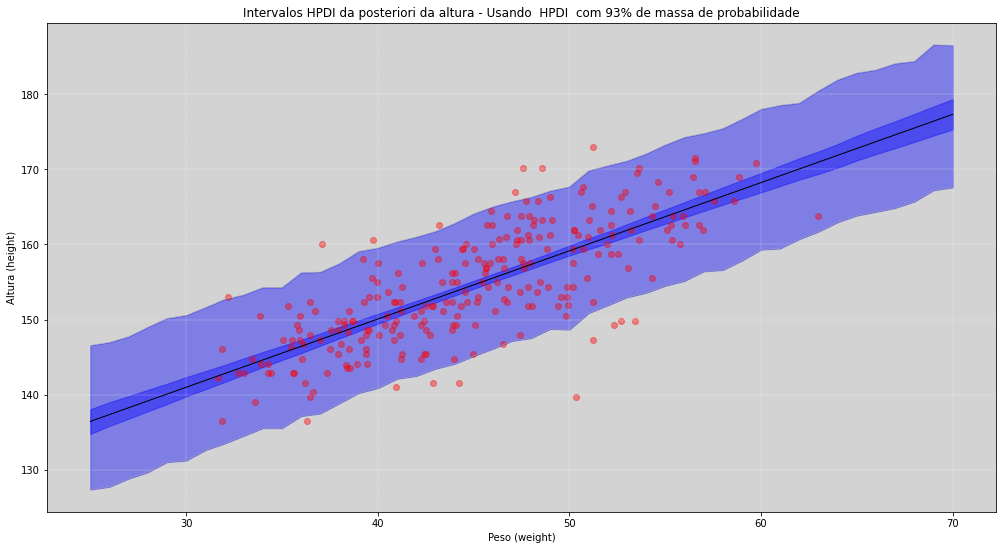

In [18]:
# ============================================================================
#     Plotando o HPDI da distribuição preditiva da alutra e de sua média
# ============================================================================

# ===========================================
# Nota: Altere o valor para ver a diferença.
# ===========================================
HPDI_range = 0.93  # Define o tamanho do intervalo do HPDI. 

posterioris_height_HPDIs = []

for weight_i in range(25, 71):
    posteiori_height = np.random.normal(alpha + beta*(weight_i - weight.mean()), sigma)
    posterioris_height_HPDIs.append(HPDI(posteiori_height, HPDI_range))
    
posterioris_height_HPDIs = np.array(posterioris_height_HPDIs)

# Plontando o gráfico
plt.figure(figsize=(17, 9))

plt.plot(range(25, 71), posterioris_height_HPDIs, color='darkgray', linewidth=0.5)
plt.fill_between(range(25, 71), posterioris_height_HPDIs[:, 0], posterioris_height_HPDIs[:, 1], color='blue', alpha=0.4)
plt.fill_between(range(25, 71), posterioris_HPDIs[:, 0], posterioris_HPDIs[:, 1], color='blue', alpha=0.4)
plt.scatter(weight, height, color='red', alpha=0.4)

plt.plot(range(25, 71), posterioris_means, color='black', linewidth=1)
plt.grid(ls='--', color='white', linewidth=0.3)
plt.title('Intervalos HPDI da posteriori da altura - Usando  HPDI  com ' + str(int(HPDI_range*100)) + '% de massa de probabilidade')
plt.ylabel('Altura (height)')
plt.xlabel('Peso (weight)')

plt.show()

Como podemos ver no gráfico acima, temos duas regiões de confiança. A região mais interna - *azul mais escura* - nos indica que esse trecho contém $89\%$ de probabilidade da `média estar ali dentro`, para cada um dos pesos.

Já a região mais externa - *aquela faixa azul mais clara* - nos indica que, com $93\%$ probabilidade, será a região mais provável da altura de um pessoa, dado um determinado peso. 

Como teste para uma melhor compreensão, faça alterações na variável `HPDI_range` para valores bem altos, por exemplo, $0.99$ e veja o quanto a faixa mais externa cobrirá os dados (*os pontos vermelhos*). Para valores menores, isso também ocorre, por exemplo, $0.7$.

Verifique!

```{warning}
A utilização de valores baixos, irá demandar cálculos mais complexos e por isso pode ser muito demorado.
```

## Curvas a partir das Linhas Retas

O interessante de modelos lineares é que eles `não são apenas lineares`, podem ser curvas também. Isso é uma coisa meio enlouquecedora sobre o termo que é convencionalmente usado para desenhar linhas retas em gráficos.

Mas uma regressão linear é `aditiva`, vamos ter que essa equação para média será a `soma de alguns parâmetros vezes algumas variáveis observadas`. Assim teremos a soma de um monte de termos. 

Temos uma equação aditiva e coisas aditivas são lineares na matemática.

Mas para nós, as palavras "adtiva" e "linear" são diferentes, então chamaremos esses modelos de `Regressões Aditivas`. Porque, podemos usar coisas que não parecem linhas retas. E, de agora até o final do capítulo, iremos fazer isso,  `desenhar curvas a partir de linhas retas`.

Mas antes de continuar, gostaria de explicar o por que é interessante aprendermos a fazer esse tipo de modelagem?

Simples! Por que a `Natureza não se limita a se manifestar por relações lineares entre  duas variáveis!` Os nossos intervalos podem ser aproximações úteis, mas geralmente são bobos.

No nosso caso, nós usamos as variáveis $altura$ e $peso$, porém apenas para indivíduos que tivessem $30$ anos ou mais. Se fossêmos usar todos os indivíduos a relação do $peso$ e a $altura$ não mais seria uma linha reta, mas sim uma curva!

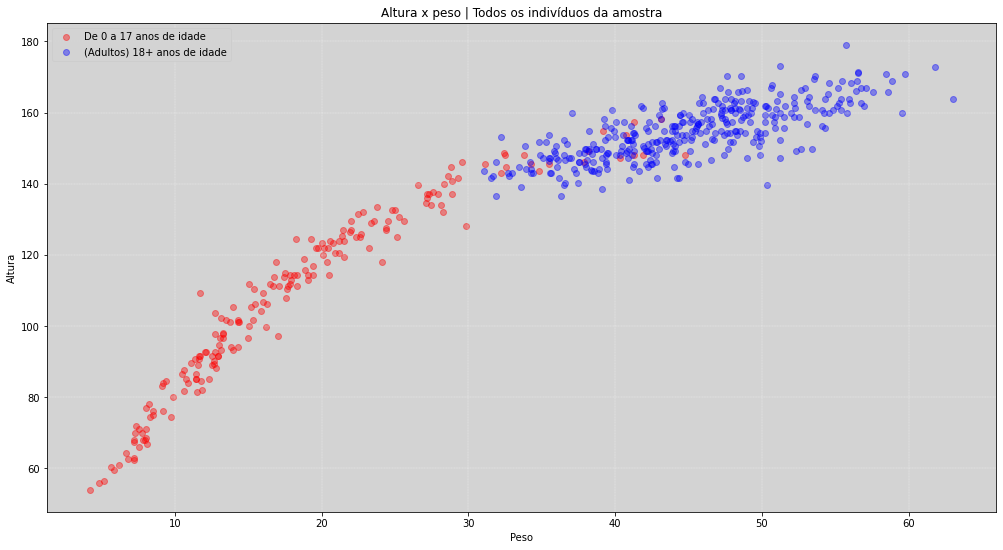

In [19]:
plt.figure(figsize=(17, 9))

# Indivíduos com menos de 18 anos de idade
height_0_18 = df.loc[df.age < 18, 'height'].values
weight_0_18 = df.loc[df.age < 18, 'weight'].values

# Indivíduos maiores (ou iguais) de 18 anos de idade - Adultos
height_18_ = df.loc[df.age >= 18, 'height'].values
weight_18_ = df.loc[df.age >= 18, 'weight'].values

# Plotando os gráficos
plt.scatter(weight_0_18, height_0_18, label='De 0 a 17 anos de idade', color='red', alpha=0.4)
plt.scatter(weight_18_, height_18_, label='(Adultos) 18+ anos de idade', color='blue', alpha=0.4)

plt.grid(ls='--', color='white', linewidth=0.3)
plt.legend()
plt.title('Altura x peso | Todos os indivíduos da amostra')
plt.xlabel('Peso')
plt.ylabel('Altura')

plt.show()

Vamos ver dois modos de construir os modelos de `Regressão Aditivas`:

- **Regressão Polinomial**
    
    - Usada de forma comum
    
    - Geralmente apresenta um comportamento bem ruim
  

Esse é um tipo bem comum de regressão, mas também é um modelo bem ruim. Não há nada de errado usar esse tipo de regressão supondo que você entenda o que *golem* está fazendo e assim usar de forma responsável. Geralmente se utilizam esse tipo de modelo sem uma devida atenção. Iremos ver o motivo dele serem mal comportados em breve.



- **Splines**

    - São muito flexíveis 
    
    - Altamente Geocêntrica
    

Existem muitos tipos de splines, mas nós iremos ver apenas as `splines de base`, que são provavelmente as mais comuns. Software de desenhos como `GIMP`, `Blender` e etc. que possuem essa ferramenta com o nome de *curvas de Bezier*, que nada mais são do que splines de base.


As Splines são muito flexíveis, muito mais flexíveis do que as Regressões Polinomiais, porém não apresentam a patologia que os polinômios apresentam e, por isso, são considerados, na maioria dos casos, melhores que as regressões polinômiais.

Porém, tanto as splines quantos as regressões polinomiais são `estratégias geocêntricas`, não há nada de científico nelas. São apenas aproximações como o * modelo de epiciclos de Ptolomeu*.

Extrapolações com esses modelos podem trazer `desastres nas predições`, por isso é necessário checar e entender o que está acontecendo com o modelo.

# Regressão Polinomial

Estratégia puramente descritiva (*geocêntrica*) usando uma variável como preditora polinomial.

- 1a Ordem (Linha): $ \mu_i = \alpha + \beta_1x_i $


- 2a Ordem (Parábola):  $\mu_i = \alpha + \beta_1x_i + \beta_2x^2_i$

### Modelo Parabólico da Altura

O modelo parabólico pode ser definido da seguinte forma:

$$ h_i \sim Normal(\mu_i, \sigma) $$


$$ \mu_i =  \alpha + \beta_1x_i + \beta_2x^2_i $$


$$ \alpha \sim Normal(178, 20) $$

$$ \beta_1 \sim  LogNormal(0, 1) $$

$$ \beta_2  \sim  Normal(0,  1) $$

$$ \sigma \sim Uniform(0,  50) $$

O problema desse modelo é que os termo $\beta_1$ e $\beta_2$ não tem um significado biológico, `isso é apenas um ajuste na curvatura da função`. Por esse motivo nós temos que simular para entender oque está acontecendo com à priori. Se não entendermos o que são essas variáveis, as nossas posterioris não teram sentido interpretativo.

```{note}
Não é para não usar! Apenas use com responsabilidade.
```

### Padronizar os Preditores

- É muito útil padronizar as variáveis preditoras antes de ajustar o modelo, temos algumas vantagens tais como:
    
    - Torna o processo de estimação mais simples
    
    - Auxília na interpretação (*algumas vezes*)
    

Para padronizar as variáveis preditoras, siga os seguinte passos para todos os dados:

- subtrair cada valor da média da amostra.

- dividir o valor obtido acima pelo desvio padrão da amostra.

- Assim, essa operação resultará em: $Média = 0$ ; $Desvio Padrão = 1$

In [20]:
# =================================================================
#       Construindo um Modelo de Regressão Parabólica | Parcial
# =================================================================

weight_full = df.weight.values  # X_i
height_full = df.height.values  # Y_i

# Utilizando os 10 primeiros dados para pessoas acimas dos 18 anos - Teste de ajuste
height_full_18 = df.loc[df.age >= 18, 'height'].head(10).values
weight_full_18 = df.loc[df.age >= 18, 'weight'].head(10).values

# Média e desvio padrão para todos os dados acima
weight_full_mean = np.mean(weight_full)
weight_full_std = np.std(weight_full)

weight_full_18_normalized = (weight_full_18 - weight_full_mean)/weight_full_std   # Padronizando as variáveis explicativa

model_stan_regression_parabolic = """
data {
    int N;
    vector[N] weight;
    vector[N] weight_2;
    vector[N] height;
}

parameters {
    real alpha;
    real<lower=0> beta_1;
    real beta_2;
    real<lower=0, upper=50> sigma;  // Priori Uniform (0, 50)
}

model {
    alpha ~ normal(178, 20);
    beta_1 ~ lognormal(0, 1);
    beta_2 ~ normal(0, 1);
    
    height ~ normal(alpha + beta_1*weight + beta_2*weight_2, sigma);
}
"""

# Construindo um dicionário com os dados
my_data = {
    'N': len(weight_full_18_normalized),
    'weight': weight_full_18_normalized ,
    'weight_2': weight_full_18_normalized ** 2,  # x_i^2
    'height': height_full_18,
}

# Rodando o modelo na Stan
posteriori = stan.build(model_stan_regression_parabolic, data=my_data)
fit = posteriori.sample(num_chains=4, num_samples=1000)

# O sufixo '_rp', usado abaixo, é referênte ao modelo de Regressão Parabólica.
alpha_rp = fit['alpha'].flatten()
beta_1_rp = fit['beta_1'].flatten()
beta_2_rp = fit['beta_2'].flatten()
sigma_rp = fit['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_dp9_99mb/model_xp7nfeoe.stan', line 17, column 24: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_dp9_99mb/model_xp7nfeoe.stan', line 17, column 19: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity param

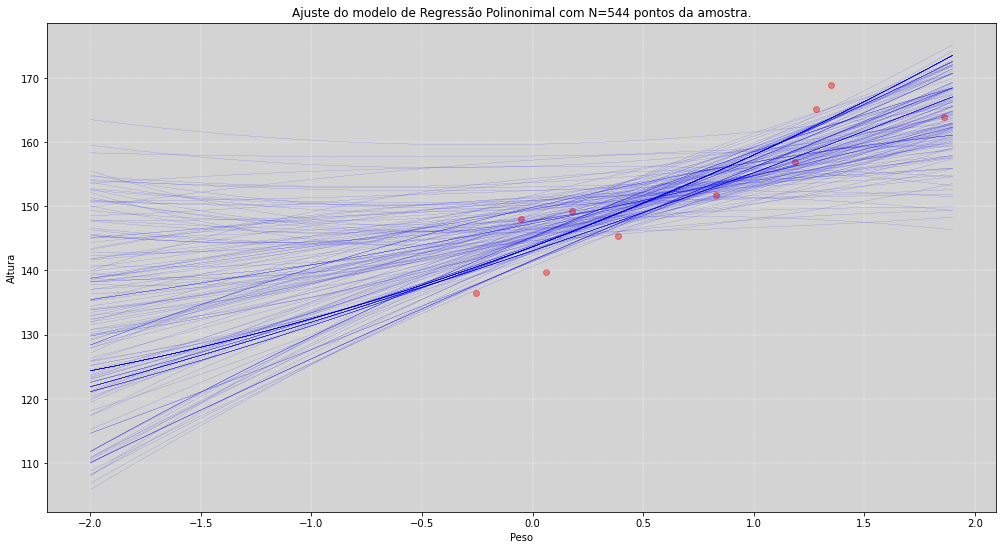

In [21]:
# ===================================================
#   Probabilidade à Posteriori de mu com N=10
# ===================================================
plt.figure(figsize=(17,9))

for i in range(200):
    mu_poli = alpha_rp[i] + beta_1_rp[i] * np.arange(-2, 2, 0.1)  + beta_2_rp[i] * (np.arange(-2, 2, 0.1)**2 )   
    plt.plot(np.arange(-2, 2, 0.1), mu_poli, color='blue', linewidth=0.1)

# Pontos da amostra
plt.scatter(weight_full_18_normalized, height_full_18, color='red', alpha=0.4)
    
plt.title('Ajuste do modelo de Regressão Polinonimal com N='+str(len(weight_full))+' pontos da amostra.')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.grid(ls='--', color='white', linewidth=0.4)


plt.show()

`Regressões Polinomiais` tem esse tipo de anomalia implícita que vimos no gráfico acima. Dentro da região dos pontos ela se comporta de modo aceitável, porém fora da região desses pontos, a função se torna descontrolada. Isso ocorre porque exitem muitas outras funções de segundo grau que podem ser ajustadas nesse conjunto de pontos. Isso não ocorre com tanta intensidade nas regressões com splines.

Perceba que para a `esquerda do zero` no eixo do peso (*peso está normalizado*) a função começa perder o controle e atinge valores que podem não ser verdadeiros.

Uma segundo inconveniente que ocorre com as Regressões Polinomiais é sua própria estrutura matemática. Apenas três parâmetros, o $\alpha$, o $\beta_1$ e o $\beta_2$, controlam todo o comportamento da curva. Isso a torna um pouco mais rígida para situações que precisamos de mais flexibilidade. As splines padrões têm, em sua construção, o pesamento de uma estrutura que evita esse tipo de inconveniente.

Lembre-se, ambos modelos, tanto os polinomiais quanto modelos com splines, são modelos *geocêntricos*. 

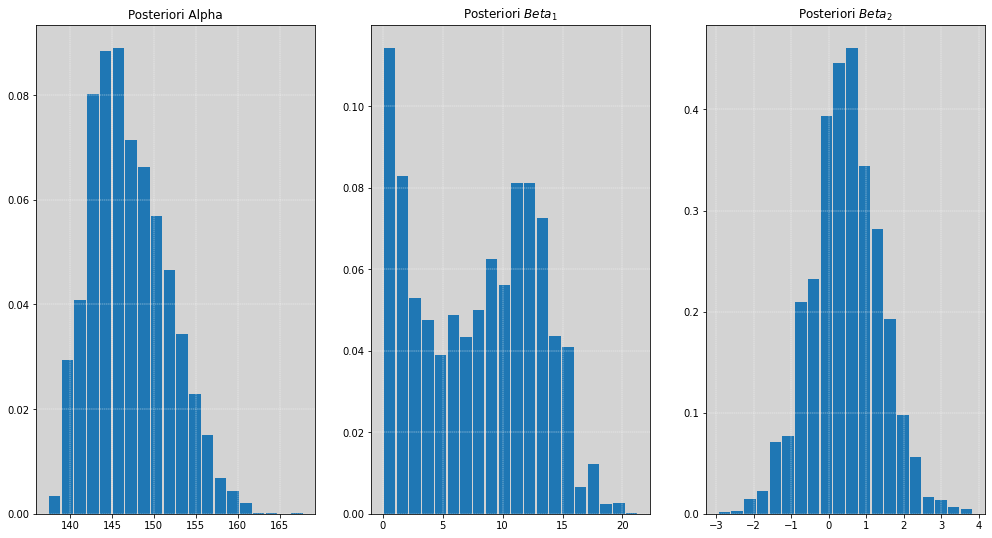

In [22]:
# =============================================================
#   Gráfico dos Histogramas das Posterioris dos Parâmentros
# =============================================================

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(17, 9))

# Histograma da posteriori do alpha
ax1.hist(alpha_rp, density=True, rwidth=0.9, bins=20)
ax1.grid(ls='--', color='white', linewidth=0.4)
ax1.set_title('Posteriori Alpha')

# Histograma da posteriori do beta_1
ax2.hist(beta_1_rp, density=True, rwidth=0.9, bins=20)
ax2.grid(ls='--', color='white', linewidth=0.4)
ax2.set_title('Posteriori $Beta_1$')

# Histograma da posteriori do beta_2
ax3.hist(beta_2_rp, density=True, rwidth=0.9, bins=20)
ax3.grid(ls='--', color='white', linewidth=0.4)
ax3.set_title('Posteriori $Beta_2$')

plt.show()

In [23]:
# ==================================================================================
#       Construindo o Modelo de Regressão Parabólica | Usando a Amostra Completa
# ==================================================================================

weight_full = df.weight.values  # X_i
height_full = df.height.values  # Y_i

weight_full_mean = np.mean(weight_full)
weight_full_std = np.std(weight_full)

weight_full_std = (weight_full - weight_full_mean)/weight_full_std   # Padronizando as variáveis explicativa

model_stan_regression_parabolic = """
    data {
        int N;
        vector[N] weight;
        vector[N] weight_2;
        vector[N] height;
    }

    parameters {
        real alpha;
        real<lower=0> beta_1;
        real beta_2;
        real<lower=0, upper=50> sigma;  // Priori Uniform (0, 50)
    }

    model {
        alpha ~ normal(178, 20);
        beta_1 ~ lognormal(0, 1);
        beta_2 ~ normal(0, 1);

        height ~ normal(alpha + beta_1*weight + beta_2*weight_2, sigma);
}
"""

my_data = {
    'N': len(weight_full_std),
    'weight': weight_full_std ,
    'weight_2': weight_full_std ** 2,
    'height': height_full,
}

posteriori = stan.build(model_stan_regression_parabolic, data=my_data)
fit = posteriori.sample(num_chains=4, num_samples=1000)

# rp := referênte ao modelo de Regressão Parabólica
alpha_rp = fit['alpha'].flatten()
beta_1_rp = fit['beta_1'].flatten()
beta_2_rp = fit['beta_2'].flatten()
sigma_rp = fit['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_41r8c22v/model_jj6jc5qn.stan', line 17, column 28: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_41r8c22v/model_jj6jc5qn.stan', line 17, column 23: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity param

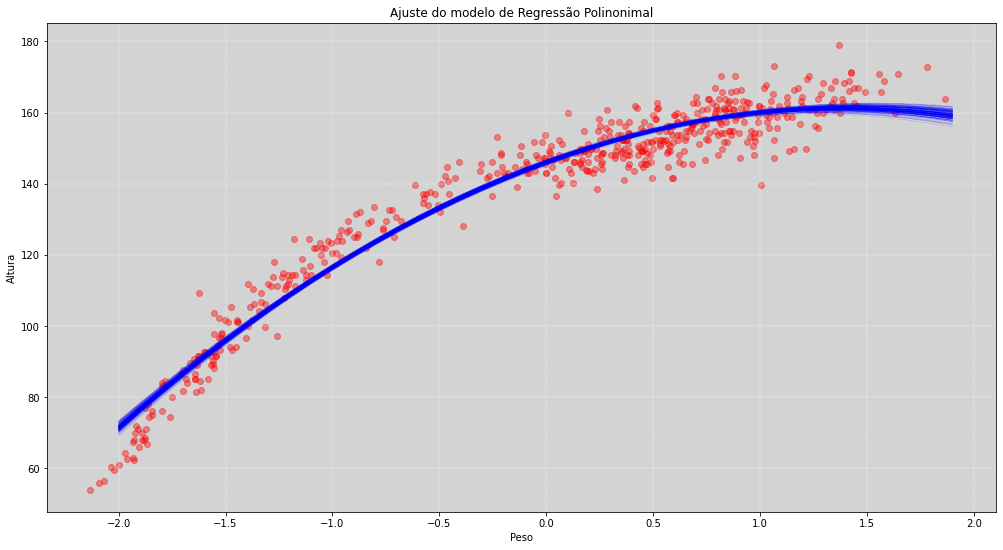

In [24]:
# ===================================================
#   Probabilidade à Posteriori de mu
# ===================================================
plt.figure(figsize=(17,9))

for i in range(200):
    mu_poli = alpha_rp[i] + beta_1_rp[i] * np.arange(-2, 2, 0.1)  + beta_2_rp[i] * (np.arange(-2, 2, 0.1)**2 )   
    plt.plot(np.arange(-2, 2, 0.1), mu_poli, color='blue', linewidth=0.1)

# Pontos da amostra
plt.scatter(weight_full_std, height_full, color='red', alpha=0.4)
    
plt.title('Ajuste do modelo de Regressão Polinonimal')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.grid(ls='--', color='white', linewidth=0.4)


plt.show()

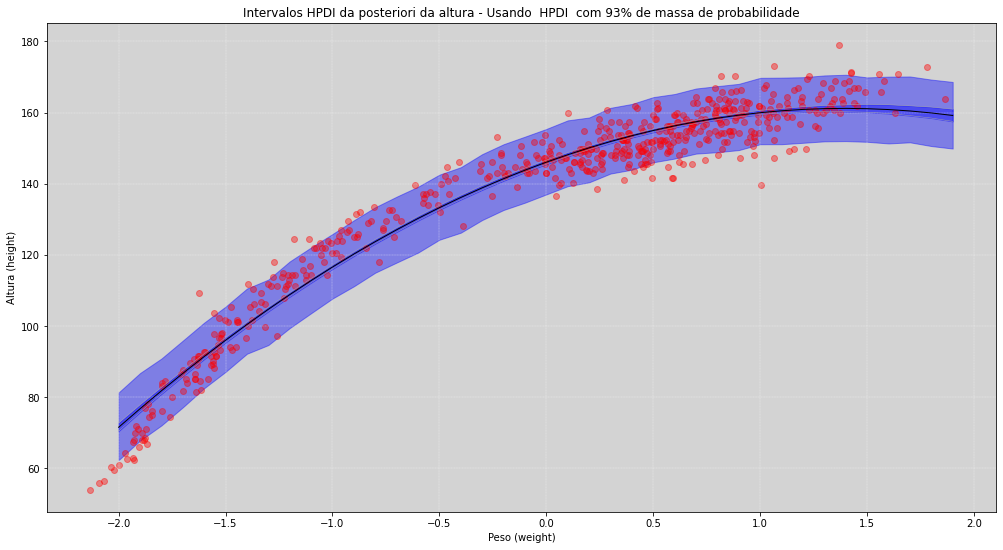

In [25]:
# ============================================
#      Probabilidade à Posteriori - HPDI
# ============================================
posteriori_polinomial2_HPDI = []
posteriori_polinomial2_mean = []
posteriori_polinomial2_sigma = []

for weight_i in np.arange(-2, 2, 0.1):
    mu_poli = alpha_rp + beta_1_rp * weight_i + beta_2_rp * weight_i**2  
    posteriori_polinomial2_mean.append(np.mean(mu_poli))  # média
    posteriori_polinomial2_HPDI.append(HPDI(mu_poli, 0.87))  # HPDI
    posteriori_polinomial2_sigma.append(HPDI(np.random.normal(mu_poli, sigma_rp), 0.89))
    
posteriori_polinomial2_HPDI = np.array(posteriori_polinomial2_HPDI)
posteriori_polinomial2_sigma = np.array(posteriori_polinomial2_sigma)

# Plontando o gráfico
plt.figure(figsize=(17, 9))

plt.plot(np.arange(-2, 2, 0.1), posteriori_polinomial2_HPDI, color='darkgray', linewidth=0.5)
plt.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial2_HPDI[:, 0], posteriori_polinomial2_HPDI[:, 1], color='blue', alpha=0.4)
plt.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial2_sigma[:, 0], posteriori_polinomial2_sigma[:, 1], color='blue', alpha=0.4)
plt.scatter(weight_full_std, height_full, color='red', alpha=0.4)

plt.plot(np.arange(-2, 2, 0.1), posteriori_polinomial2_mean, color='black', linewidth=1)
plt.grid(ls='--', color='white', linewidth=0.3)
plt.title('Intervalos HPDI da posteriori da altura - Usando  HPDI  com ' + str(int(HPDI_range*100)) + '% de massa de probabilidade')
plt.ylabel('Altura (height)')
plt.xlabel('Peso (weight)')

plt.show()

# Modelos Cúbicos

Seguindo o mesmo raciocínio acima, vamos implementar o modelo de Regressão Polinômial de grau 3. Abaixo temos a evolução dos modelos apresentados:

- 1a Ordem (Linha): $ \mu_i = \alpha + \beta_1x_i $


- 2a Ordem (Parábola):  $\mu_i = \alpha + \beta_1x_i + \beta_2x^2_i$


- 3a Ordem (Função Cúbica):  $\mu_i = \alpha + \beta_1x_i + \beta_2x^2_i + \beta_3x^3_i$

## Modelo Regressão Cúbico para a Altura

O modelo para estimar a altura usando a função polinômial cúbica pode ser definida da seguinte forma:

$$ h_i \sim Normal(\mu_i, \sigma) $$


$$ \mu_i =  \alpha + \beta_1x_i + \beta_2x^2_i + \beta_3x^3_i$$


$$ \alpha \sim Normal(178, 20) $$

$$ \beta_1 \sim  LogNormal(0, 1) $$

$$ \beta_2  \sim  Normal(0,  1) $$

$$ \beta_3  \sim  Normal(0,  1) $$

$$ \sigma \sim Uniform(0,  50) $$

In [26]:
# ==============================================================================================
#       Construindo o Modelo de Regressão Parabólica de 3 Grau | Usando a Amostra Completa
# ==============================================================================================

weight_full = df.weight.values  # X_i
height_full = df.height.values  # Y_i

weight_full_mean = np.mean(weight_full)
weight_full_std = np.std(weight_full)

weight_full_std = (weight_full - weight_full_mean)/weight_full_std   # Padronizando as variáveis explicativa

model_stan_regression_parabolic_3 = """
data {
    int N;
    vector[N] weight;
    vector[N] weight_2;
    vector[N] weight_3;
    vector[N] height;
}

parameters {
    real alpha;
    real beta_1;
    real beta_2;
    real beta_3;
    real<lower=0, upper=50> sigma;  // Priori Uniform (0, 50)
}

model {
    alpha ~ normal(178, 20);
    beta_1 ~ lognormal(0, 1);
    beta_2 ~ normal(0, 1);
    beta_3 ~ normal(0, 1);
    
    height ~ normal(alpha + beta_1*weight + beta_2*weight_2 + beta_3*weight_3, sigma);
}
"""

my_data = {
    'N': len(weight_full_std),
    'weight': weight_full_std ,
    'weight_2': weight_full_std ** 2,
    'weight_3': weight_full_std ** 3,
    'height': height_full,
}

posteriori_p3 = stan.build(model_stan_regression_parabolic_3, data=my_data)

fit_p3 = posteriori_p3.sample(num_chains=4, num_samples=1000)

# rp := referênte ao modelo de Regressão Parabólica
alpha_rp3 = fit_p3['alpha'].flatten()
beta_1_rp3 = fit_p3['beta_1'].flatten()
beta_2_rp3 = fit_p3['beta_2'].flatten()
beta_3_rp3 = fit_p3['beta_3'].flatten()
sigma_rp3 = fit_p3['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_b6eq8ask/model_rmzvbf4t.stan', line 20, column 4: Parameter
    beta_1 is given a lognormal distribution, which has strictly positive
    support, but beta_1 was not constrained to be strictly positive.
Warning in '/tmp/httpstan_b6eq8ask/model_rmzvbf4t.stan', line 19, column 24: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_b6eq8ask/model_rmzvbf4t.stan', line 19, column 19: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient 

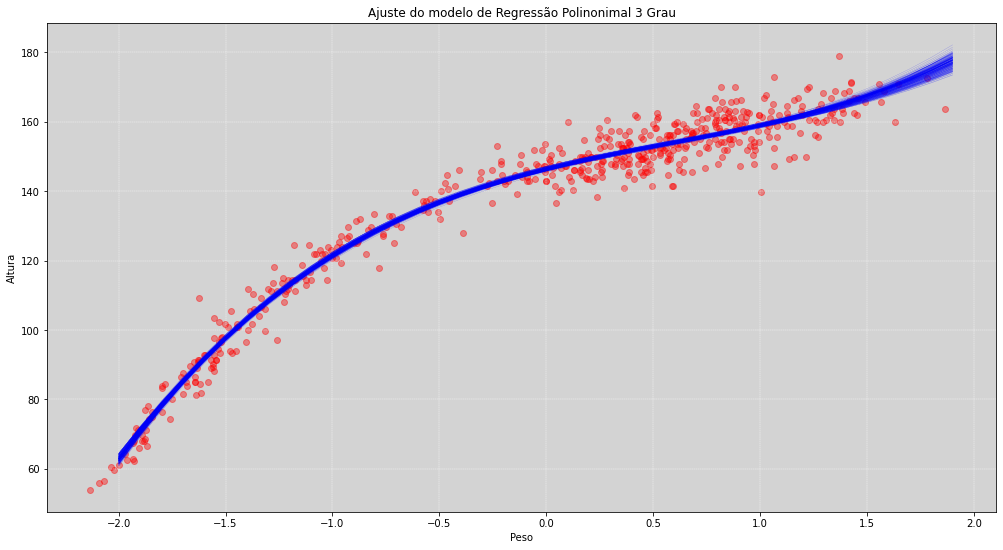

In [27]:
# ======================================
#   Probabilidade à Posteriori de mu
# ======================================
plt.figure(figsize=(17,9))

for i in range(200):
    mu_poli3 = alpha_rp3[i] + \
              beta_1_rp3[i] * np.arange(-2, 2, 0.1) + \
              beta_2_rp3[i] * (np.arange(-2, 2, 0.1)**2) + \
              beta_3_rp3[i] * (np.arange(-2, 2, 0.1)**3)
                
    plt.plot(np.arange(-2, 2, 0.1), mu_poli3, color='blue', linewidth=0.1)

# Pontos da amostra
plt.scatter(weight_full_std, height_full, color='red', alpha=0.4)
    
plt.title('Ajuste do modelo de Regressão Polinonimal 3 Grau')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.grid(ls='--', color='white', linewidth=0.4)


plt.show()

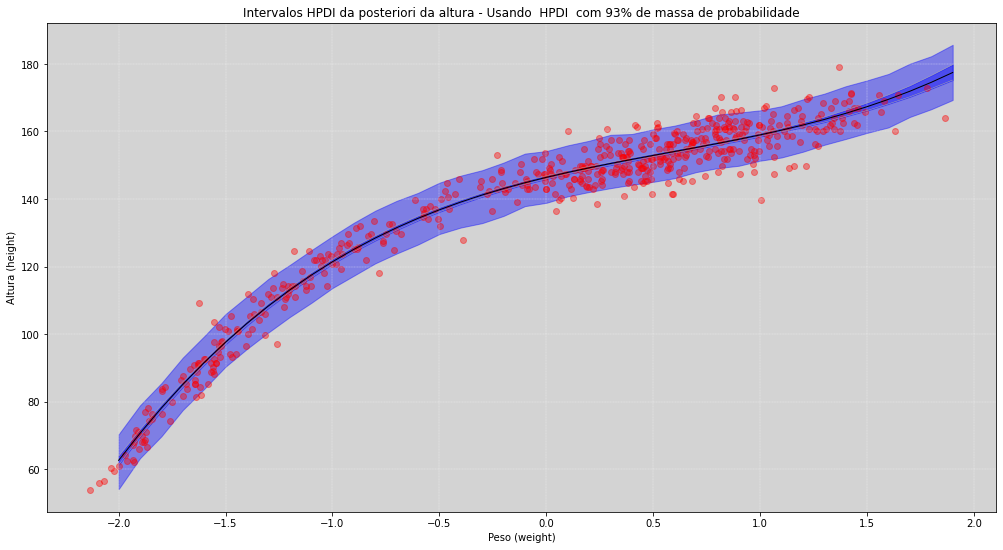

In [28]:
# ============================================
#      Probabilidade à Posteriori - HPDI 
# ============================================
posteriori_polinomial3_mean = []
posteriori_polinomial3_HPDI = []
posteriori_polinomial3_sigma = []

for weight_i in np.arange(-2, 2, 0.1):
    mu_poli3 = alpha_rp3 + beta_1_rp3 * weight_i + beta_2_rp3 * weight_i**2 + beta_3_rp3 * weight_i**3 
    posteriori_polinomial3_mean.append(np.mean(mu_poli3))  # média
    posteriori_polinomial3_HPDI.append(HPDI(mu_poli3, 0.87))  # HPDI
    posteriori_polinomial3_sigma.append(HPDI(np.random.normal(mu_poli3, sigma_rp3), 0.89))
    
posteriori_polinomial3_HPDI = np.array(posteriori_polinomial3_HPDI)
posteriori_polinomial3_sigma = np.array(posteriori_polinomial3_sigma)

# Plontando o gráfico
plt.figure(figsize=(17, 9))

plt.plot(np.arange(-2, 2, 0.1), posteriori_polinomial3_HPDI, color='darkgray', linewidth=0.5)
plt.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial3_HPDI[:, 0], posteriori_polinomial3_HPDI[:, 1], color='blue', alpha=0.4)
plt.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial3_sigma[:, 0], posteriori_polinomial3_sigma[:, 1], color='blue', alpha=0.4)
plt.scatter(weight_full_std, height_full, color='red', alpha=0.4)

plt.plot(np.arange(-2, 2, 0.1), posteriori_polinomial3_mean, color='black', linewidth=1)
plt.grid(ls='--', color='white', linewidth=0.3)
plt.title('Intervalos HPDI da posteriori da altura - Usando  HPDI  com ' + str(int(HPDI_range*100)) + '% de massa de probabilidade')
plt.ylabel('Altura (height)')
plt.xlabel('Peso (weight)')

plt.show()

In [29]:
# =====================================================================================
#     Construindo o modelo de 1 grau (novamente) para a comparação | Regressão Linear
# =====================================================================================

height_p1 = df.height.values
weight_p1 = df.weight.values

weight_p1_s = (weight_p1 - weight_p1.mean())/np.std(weight_p1)

model_stan_polinomio_1 = """
    data {
        int N;
        vector[N] weight;
        vector[N] height;
    }

    parameters {
        real alpha;
        real beta;
        real<lower=0, upper=50> sigma;
    }

    model {
        alpha ~ normal(178, 20);
        beta ~ lognormal(0, 1);
        
        height ~ normal(alpha + beta*weight, sigma);
    }
"""
data = {
    'N': len(height_p1),
    'weight': weight_p1_s,
    'height': height_p1,
}

posteriori_p1 = stan.build(model_stan_polinomio_1, data=data)
fit_p1 = posteriori_p1.sample(num_chains=4, num_samples=1000)

alpha_p1 = fit_p1['alpha'].flatten()
beta_p1 = fit_p1['beta'].flatten()
sigma_p1 = fit_p1['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan__23pozf3/model_2eqnracv.stan', line 16, column 8: Parameter
    beta is given a lognormal distribution, which has strictly positive
    support, but beta was not constrained to be strictly positive.
Warning in '/tmp/httpstan__23pozf3/model_2eqnracv.stan', line 15, column 28: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__23pozf3/model_2eqnracv.stan', line 15, column 23: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient indu

In [30]:
# =========================================================
#  Calculando os intervalos de HPDI para o modelo linear
# =========================================================

posterioris_height_HPDIs_p1_mean = []
mu_HPDI_p1 = []
posteriori_HPDI_p1 = []


for weight_i in np.arange(-2, 2, 0.1):
    posterioris_height_HPDIs_p1_mean.append(np.mean(alpha_p1 + beta_p1 * weight_i))
    mu_HPDI_p1.append(HPDI(alpha_p1 + beta_p1 * weight_i, 0.87))
    posteriori_HPDI_p1.append(HPDI(np.random.normal(alpha_p1 + beta_p1 * weight_i, sigma_p1), 0.85))
    
posterioris_height_HPDIs_p1 = np.array(mu_HPDI_p1)
mu_HPDI_p1 = np.array(mu_HPDI_p1)
posteriori_HPDI_p1 = np.array(posteriori_HPDI_p1)

[]

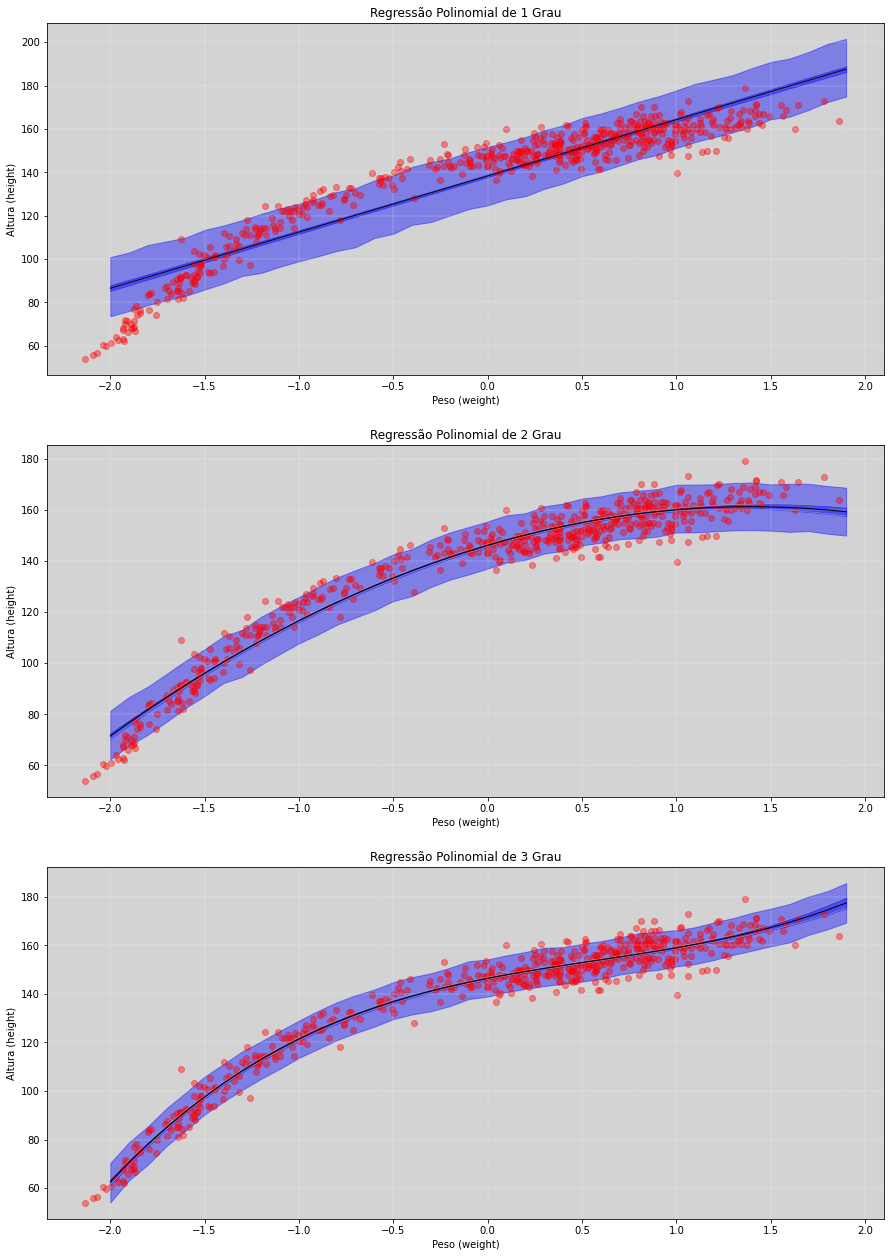

In [31]:
# ==================================================
#     Comparativo dos três modelos polinomiais 
#             de 1º, 2º e 3º grau
#         para estimativa das alturas!
# ==================================================

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15, 22))

# ===============================================================================
#     Plotando o gráfico de regressão polinomial de grau 1 - Modelo Linear
# ===============================================================================
ax1.plot(np.arange(-2, 2, 0.1), posterioris_height_HPDIs_p1_mean, color='darkgray', linewidth=0.5)
ax1.fill_between(np.arange(-2, 2, 0.1), mu_HPDI_p1[:, 0], mu_HPDI_p1[:, 1], color='blue', alpha=0.4)
ax1.fill_between(np.arange(-2, 2, 0.1), posteriori_HPDI_p1[:, 0], posteriori_HPDI_p1[:, 1], color='blue', alpha=0.4)
ax1.scatter(weight_full_std, height_full, color='red', alpha=0.4)

ax1.plot(np.arange(-2, 2, 0.1), posterioris_height_HPDIs_p1_mean, color='black', linewidth=1)
ax1.grid(ls='--', color='white', linewidth=0.3)
ax1.set_title('Regressão Polinomial de 1 Grau')
ax1.set_ylabel('Altura (height)')
ax1.set_xlabel('Peso (weight)')


# ===============================================================================
#     Plotando o gráfico de regressão polinomial de grau 2 - Parábola
# ===============================================================================
ax2.plot(np.arange(-2, 2, 0.1), posteriori_polinomial2_HPDI, color='darkgray', linewidth=0.5)
ax2.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial2_HPDI[:, 0], posteriori_polinomial2_HPDI[:, 1], color='blue', alpha=0.4)
ax2.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial2_sigma[:, 0], posteriori_polinomial2_sigma[:, 1], color='blue', alpha=0.4)
ax2.scatter(weight_full_std, height_full, color='red', alpha=0.4)

ax2.plot(np.arange(-2, 2, 0.1), posteriori_polinomial2_mean, color='black', linewidth=1)
ax2.grid(ls='--', color='white', linewidth=0.3)
ax2.set_title('Regressão Polinomial de 2 Grau')
ax2.set_ylabel('Altura (height)')
ax2.set_xlabel('Peso (weight)')

# ===============================================================================
#     Plotando o gráfico de regressão polinomial de grau 3 - Função Cúbica
# ===============================================================================

ax3.plot(np.arange(-2, 2, 0.1), posteriori_polinomial3_HPDI, color='darkgray', linewidth=0.5)
ax3.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial3_HPDI[:, 0], posteriori_polinomial3_HPDI[:, 1], color='blue', alpha=0.4)
ax3.fill_between(np.arange(-2, 2, 0.1), posteriori_polinomial3_sigma[:, 0], posteriori_polinomial3_sigma[:, 1], color='blue', alpha=0.4)
ax3.scatter(weight_full_std, height_full, color='red', alpha=0.4)

ax3.plot(np.arange(-2, 2, 0.1), posteriori_polinomial3_mean, color='black', linewidth=1)
ax3.grid(ls='--', color='white', linewidth=0.3)
ax3.set_title('Regressão Polinomial de 3 Grau')
ax3.set_ylabel('Altura (height)')
ax3.set_xlabel('Peso (weight)')

plt.plot()

O que fizemos aqui foi escolher uma forma matemática polinômial (*um polinômio de primeiro, de segundo ou de terceiro grau*) e ajustarmos a melhor estrutura em cada um deles usando os dados da amostra.

Como temos muitos dados, a nossa incerteza tende a ficar muito pequena, o que pode nos levar a achar que o modelo está bem ajustado. 

```{note}
As linhas não endossam o modelo. O que faz mais sentido é que o modelo endosse as linhas!  
```

Por isso temos que saber ser críticos com os modelos e sobre a sua estrutura geral, porque o modelo nunca fará isso por si mesmo. `Ele não tem responsabilidade e capacidade para fazer isso`. É de nossa responsabilidade fazer essa crítica, senão iremos *destruir Praga*.


Podemos perceber que essas linhas não se ajustam, de modo geral, tão bem assim aos dados, e também não há muita incerteza de onde elas estão. Isso é bem interessante, os intervalos de confiabilidade são minúsculos, mas o ajuste nos dados foi um ajuste ruim, o` modelo tem pouca incerteza, mas é um modelo ruim`. 

Outro problema dos polinômios é que ele são monotônicos, ou seja, depois de certo estágio eles tendem a seguir indefinidamente até o infinito. 

Não há oscilações desse modelo! É um modelo mais duro de manipular!

## Dores dos Polinômios

- Polinômios fazem previsões absurdas fora do range dos dados.


- Os parâmetros influenciam cada parte do corpo da curva, isso torna difícil de se entender.


- Não são muito flexíveis, podem ter curvas monotônicas.


Essas perdas de estabilidade também podem ocorrer dentro do range dos dados, iremos ver bem mais para frente um exemplo disso. 

# Splines

<img src='./images/splines_boat.jpg' alt="splines in boat" width=1000>

Então, o que fazer agora para não precisarmos enfrentar os maus comportamentos dos polinômios?

Existem muitas outras opções. A que vamos ver aqui é uma bastante comum e realmente útil no dia-a-dia. Mas, ainda assim, contínua sendo um modelo *geocêntrico*. `Assim como todos os outros modelos!` Por isso, precisamos ter responsabilidades com o modelo e `não interpreta-lo demais`.


As splines sugiram de uma motivação física. `Spline` é nome bastante estranho, mas é apenas a *barrinha* (de madeira ou de aço), como na foto acima.  Essa barra é recuada e fixada pontualmente (*pivot point*) pelos pesos de metal ao longo de seu comprimento. Vamos chamar esses pesos de `nós` (*`knots`*). Essa estrutura ainda hoje é usada por desenhistas para traçar a curvas de cascos de barcos. 

## Agindo Localmente - *B-splines*

`Splines de base`, ou no inglês *basis-splines*, naturalmente são chamadas de `B-splines`. São funções que todos os seus parâmetros têm efeitos locais apenas e não globalmente como nos foi visto nos polinômios. São funções *wiggly*. Essa classe de funções é construída com outras funções *wigglys* locais. 

Vamos ver um exemplo, mas devemos sempre nos lembrar de que estamos construindo um modelo *geocêntrico*, e que este está apenas descrevendo o comportamento dos dados na estrutura do nosso modelo e não explicando eles. Iremos observar esses resultados para as fazer previsões, portanto, devemos ter `responsabilidades sobre como funciona um modelo`.


`Funções de base` são apenas funções locais, e toda a spline é construída com interpolações, deslizando suavemente entre essas funções locais, ou seja, as funções de base (*basis functions*). 

Para ficar mais claro, nós iremos construir uma grande *wiggly functions* a partir de outras *wiggly functions* menores. Mas cada uma dessas funções wiggly menores tem parâmetros locais que descrevem a sua própria importância. Nós iremos ajustá-los e poderemos observar que não ocorrerá aquelas oscilações bruscas como ocorreu nas regressões polinomiais.

```{note}
Esses modelos são geralmente melhores do que os modelos polinômiais, mas igualmente *geocêntricos*!
```

`B-Splines bayesianas` são geralmente chamadas de `P-splines`. É usado comumente em pessoas que usam *Machine Learning*. O `P` significa *penalidades* que a priori dá para os pesos, mas foram rotulados dessa forma em contextos *não bayesianos*.

Mais para frente no curso iremos ver melhor os conceitos de penalidades e ficará bem mais claro o seu uso.

`B-splines` são apenas uma variação dos modelos lineares que vimos anteriormente. Também é um `modelo aditivo` que tem algumas variáveis sintéticas estranhas (ou seja, *não observáveis*).

O modelo pode ser escrito da seguinte forma:

$$ \mu_i = \alpha + w_1B_{i, 1}+ w_2B_{i, 2}+ w_3B_{i, 3}+ ...  $$

Os pesos $w_i$ são como as inclinações. Isso é meio estranho porque o preditor de interesse não irá aparecer no modelo, no entanto, teremos uma aproximação fantástica da relação entre os preditores de interesse e o resultado. 

```{warning}
Parece estranho, mas funciona super bem.
```

As funções de bases (*basis functions*) $B$ são variáveis sintéticas. Internamente elas são termos quadráticos ou termos cúbicos. Mas note que os dados não foram usados para construir $B$. Os valores de $B$ associam pesos em diferentes regiões da variável $x$.


Vamos construir um exemplo, passo-a-passo, de como construir um modelos de tipo.

Para isso, vamos utilizar os dados do Milenar Festival de Flores de Cerejeira no Japão.

## Festival das Flores de Cerejeira

<img src='./images/cherry_blossoms.jpg' alt='Cherry Blossoms' width=1000>

*Cherry blossoms at Sugimura park, Hashimoto*
[Wikipedia](https://en.wikipedia.org/wiki/Cherry_blossom)

Agora iremos usar os dados do histórico do festival japonês das flores de cerejeiras. O primeiro registro de uma flor de cerejeira nesse festival foi registrada a $1200$ anos atrás e, agora, nós temos esses dados para podermos explorar e entendê-los melhor.

Na nossa base de dados temos a variável tempo, `year`, correspondente a cada ano de coleta dos dados. Temos os dados da época da floração e também dados da temperatura. A temperatura tem influência direta na floração das árvores pelo natural processo biológico.

Como podemos imaginar, essa relação é afetada pelas oscilações dos processos climáticos ao longo dos anos. Por agora nós iremos olhar para os dados da temperatura ao longo dos anos. Mas para frente ao longo do curso, iremos relacionar mais variáveis.

Fique como exercício construir um modelo linear da `temperatura` explicando a `data do florecimento` (*doy*), existe um relacionamento muito forte e entenderemos o porquê disso. 

In [32]:
cherry_df = pd.read_csv('./data/cherry_blossoms.csv', sep=';')
cherry_df.describe()

year         doy         temp   temp_upper   temp_lower
count  1215.000000  827.000000  1124.000000  1124.000000  1124.000000
mean   1408.000000  104.540508     6.141886     7.185151     5.098941
std     350.884596    6.407036     0.663648     0.992921     0.850350
min     801.000000   86.000000     4.670000     5.450000     0.750000
25%    1104.500000  100.000000     5.700000     6.480000     4.610000
50%    1408.000000  105.000000     6.100000     7.040000     5.145000
75%    1711.500000  109.000000     6.530000     7.720000     5.542500
max    2015.000000  124.000000     8.300000    12.100000     7.740000

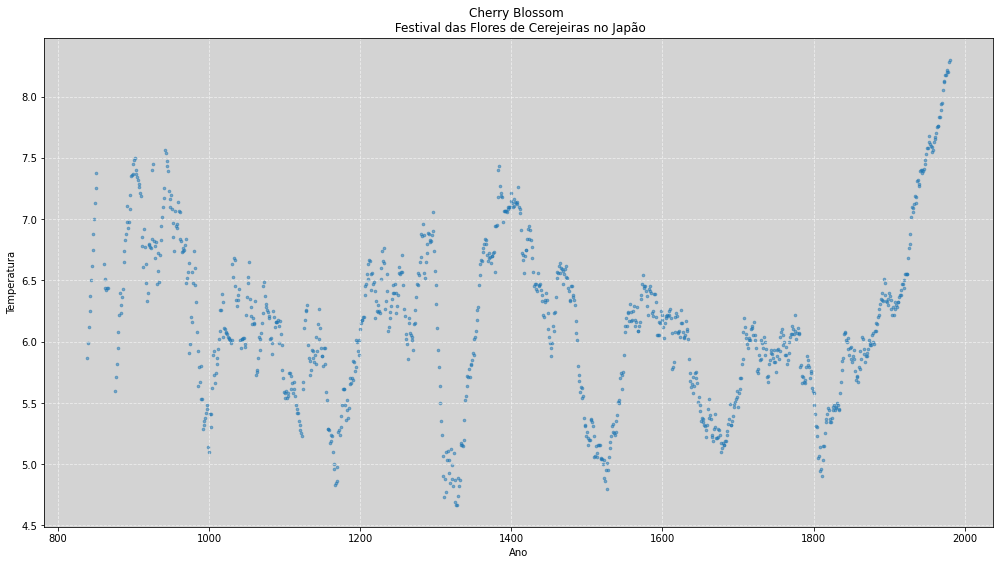

In [33]:
plt.figure(figsize=(17, 9))

plt.scatter(cherry_df.year, cherry_df.temp, marker='o', alpha=0.5, s=7)
plt.title('Cherry Blossom \n Festival das Flores de Cerejeiras no Japão')
plt.xlabel('Ano')
plt.ylabel('Temperatura')
plt.grid(ls='--', color='white', alpha=0.6)
plt.show()

Nosso objetivo aqui é construir uma tendência com esses registros de temperaturas, o que significa que queremos estimar uma spline para esses dados.


Se quisermos observar uma tendência em uma determida escala para compará-lás a algum movimento, então iremos precisar construir uma tendência em uma escala específica.


O que iremos fazer aqui é trabalhar com a ideia de obter alguma aproximação da série com alguma qualidade arbitrária. Nós iremos começar com uma `aproximação bastante ruim` para entender as *wiggly functions* e após isso iremos construir modelos mais complexos e com melhores aproximações usando uma *`B-splines`*.

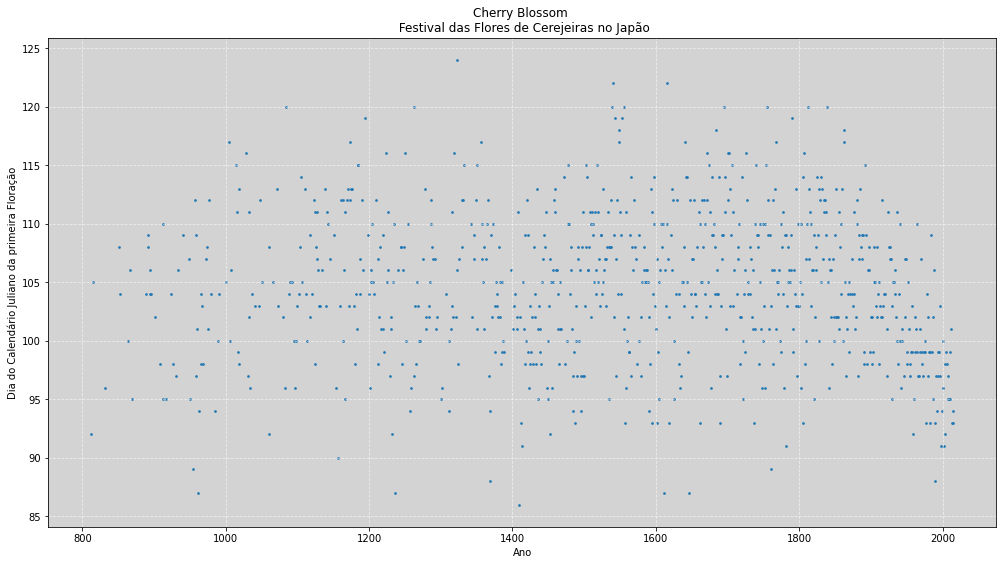

In [34]:
# ===================================================
#     Gráfico de Primeiro dia de Floração x anos
# ===================================================

plt.figure(figsize=(17, 9))

plt.scatter(cherry_df.year, cherry_df.doy, marker='o', alpha=0.9, s=3)
plt.title('Cherry Blossom \n Festival das Flores de Cerejeiras no Japão')
plt.xlabel('Ano')
plt.ylabel('Dia do Calendário Juliano da primeira Floração')
plt.grid(ls='--', color='white', alpha=0.6)
plt.show()

### Como as splines funcionam?

Aqui está um passo a passo de como construirmos uma splines.


- **Escolha alguns nós (*knots*)**: localização da variável preditora onde a spline é ancorada! Assim determinaremos o local onde aquelas peças pesadas irão estar ao longo da barrinha. Matemáticamente são os pontos de base fazem o pivô e determinam as lacunas entre as splines de base. 


- **Escolha os graus da função de base**: o quanto é *wiggly*. Iremos demonstrar graficamente esse conceito sobre a utilização dos graus no decorrer da explicação. 


- **Encontre a distribuição à posteriori dos pesos**: como anteriormente iremos fazer a estimativa bayesiana dos pesos, muito próximos como fizemos nos outos modelos de regressão.

### Knots - Como escolher os pontos?

Exite uma ampla literatura sobre abordagens de como devemos escolher esses pontos. Uma dos métodos mais comuns e eficientes são distribuí-los de acordo com seus *quantis*, pois assim podemos distribuir mais pontos onde há um acúmulo maior dos dados. 

Geralmente pacotes e livrarias computacionais já nos trazem essas escolhas de modo automático e, de uma certa forma, mágicos! Nós iremos construir todo o modelo manualmente, para que possamos entender os seus detalhes de seu funcionamento. 

O que vamos propor é colocar um *knot* na mediana, um *knot* em cada extremidade e outros dois nos centros laterais, conforme mostrado no gráfico abaixo.

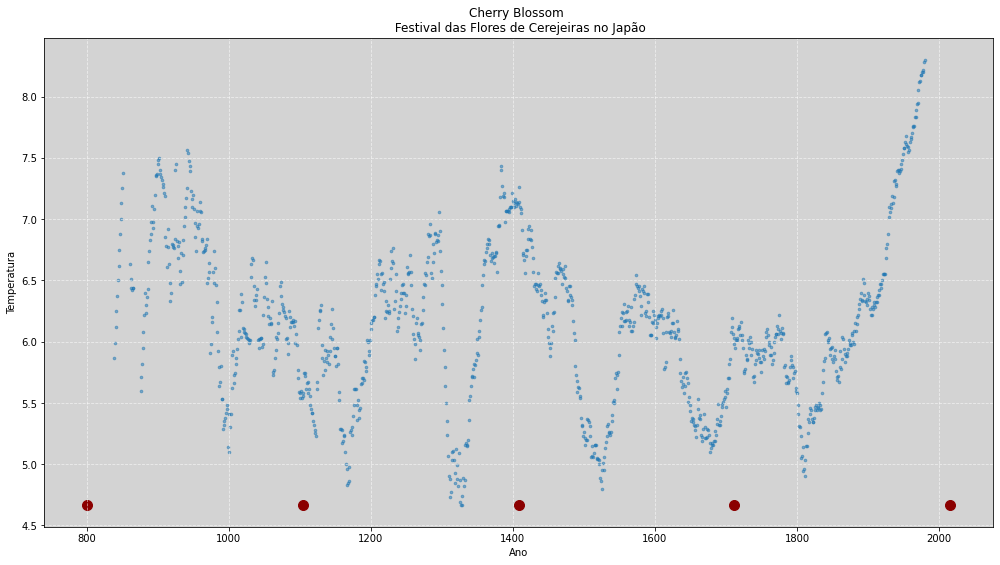

In [35]:
# Configurando a variável de tempo.
year = cherry_df.year.values

qty_knots = 5  # Quantidade de nós que iremos usar.
knots_array = np.linspace(0, 1, qty_knots)

# Ref: https://numpy.org/doc/stable/reference/generated/numpy.isfinite.html?highlight=isfinite#numpy.isfinite
year = year[np.isfinite(year)]  # Removendo os elementos NaN's

# Encontrando os knots tomando como base os quantiles
knots = np.quantile(year, knots_array)
knots = [int(x) for x in knots]  # Convertendo os valores do Knots para inteiro

# Plotando os pontos dos nós - Knots.
plt.figure(figsize=(17, 9))

plt.scatter(cherry_df.year, cherry_df.temp, marker='o', alpha=0.5, s=7)
plt.scatter(knots, np.ones(len(knots)) * min(cherry_df.temp[cherry_df.temp > 0]), s=100, color='darkred')

plt.title('Cherry Blossom \n Festival das Flores de Cerejeiras no Japão')
plt.xlabel('Ano')
plt.ylabel('Temperatura')
plt.grid(ls='--', color='white', alpha=0.6)
plt.show()

Vamos agora construir as splines em seus nós (*knots*). Iremos desenhar abaixo todas as variáveis sintéticas. Os valores das variáveis sintéticas são construídas ao longo de todo intervalo da variável `ano`. E então queremos interpolar os dados.

Uma das maneiras de se pensar a respeito disso é pensar o ano como uma variável na qual nunca iremos usar novamente, usaremos apenas para definir os *knots* como âncoras sobre alguns anos específicos, mas nunca usaremos esses dados novamente.

Para começar, iremos construir algumas simples `funções de base` (*basis functions*). Vamos começar com as funções de bases  mais simples, funções de base de grau 1, o que é uma linha reta. Com isso iremos construir uma *wiggly functions* composta de várias funções de base de primeiro grau, que são a junções daquelas linhas retas.

<img src="./images/splines_2.jpg" alt="splines com pesos" width=500>

Para a construção das splines, iremos usar a função disponível na biblioteca *SciKit Learn* e sua documentação pode ser acessada [clicando aqui.](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html#examples-using-)

In [36]:
from sklearn.preprocessing import SplineTransformer

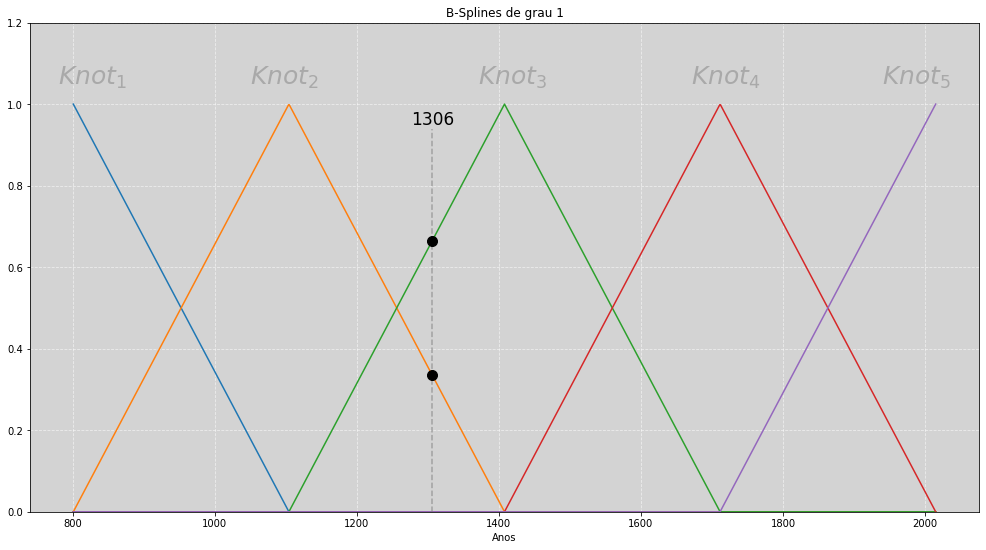

In [37]:
# ======================================
#     Construindo a Spline - Ordem 1
# ======================================

x = np.arange(year.min(), year.max()+1).reshape((year.max() - year.min() + 1), 1)

spline_1 = SplineTransformer(degree=1, n_knots=5)  # É utilizado um intervalo equidistante entre os quantis, por padrão. 
spline_1 = spline_1.fit_transform(x)
plt.figure(figsize=(17, 9))

plt.plot(x, spline_1)

marco_eixo_x = 1306  # Local no eixo X que a linha tracejada será plotada
marco_eixo_y_cima = spline_1[marco_eixo_x - cherry_df.year.min(), 2]
marco_eixo_y_baixo = spline_1[marco_eixo_x - cherry_df.year.min(), 1]

plt.vlines(marco_eixo_x, 0, 0.94, color='gray', ls='--', alpha=0.6)  # Linha tracejada vertical

plt.plot(marco_eixo_x, marco_eixo_y_cima, marker='o', color='black', ms=10)  # Ponto de marcação de cima
plt.plot(marco_eixo_x, marco_eixo_y_baixo, marker='o', color='black', ms=10)  # Ponto de marcação de baixo

plt.text(marco_eixo_x - 30, 0.95, str(marco_eixo_x), size=17, color='black')

plt.title('B-Splines de grau 1')
plt.xlabel('Anos')
plt.text(780, 1.05,'$Knot_1$', size=25, color='darkgray')
plt.text(1050, 1.05,'$Knot_2$', size=25, color='darkgray')
plt.text(1370, 1.05,'$Knot_3$', size=25, color='darkgray')
plt.text(1670, 1.05,'$Knot_4$', size=25, color='darkgray')
plt.text(1940, 1.05,'$Knot_5$', size=25, color='darkgray')

plt.grid(ls='--', color='white', alpha=0.6)
plt.ylim((0, 1.2))
plt.show()

Assim como as splines para os desenhistas, nós, estatísticos, usamos elas de modos semelhantes em matemática. No gráfico acima plotamos $5$ funções de bases (*basis-functions*) tendo como ponto central os nós (*knots*) que definimos anteriormente.


Para entendermos o funcionamento dessa estrutura, temos que perceber 2 coisas: Os dois pontos pretos que estão plotados no gráfico acima, esses pontos sempre estarão sobre 2 funções de base, por exemplo na função referente ao nó 2 *($knot_2$)* e ao nó 3 *($knot_3$)*. Isso sempre será verdade, exceto quando a posição do `eixo x` estiver exatamente sobre a posição de alguns do nós. 


A próxima observação é que cada uma das funções de base será multiplicada por um número, esse número irá modificar a sua estrutura podendo aumenta-lá ou a encurtar. Esse peso, como veremos mais adiante, será rotulado de $w$. Assim, após essa modificação ser aplicada em todas as curvas, iremos somar todos os pontos pretos e obteremos a nossa *B-spline*, ou seja, uma nova curva que é a resultante da soma de todas as curvas multiplicadas por seus respectivos pesos.

O interessante que notamos aqui é que, na regressão polinomial usamos as variáveis explicativas (*$X$*) da nossa amostra com alguns ajustes, elevado ao quadrado ou elevado ao cubo, para construção do nosso modelo. No modelo de splines que iremos construir, a variável explicativa é uma variável sintética, ou seja, `uma variável que nós criamos e que não tem nenhuma relação com o modelo em si`.

O que buscamos com o modelo de splines é estimar **quais seriam os pesos mais plausíveis** que melhor descreve nossos dados. Parece muito estranho fazer isso, mais funciona muito bem! 

Vamos ver um exemplo de como isso acontece... 

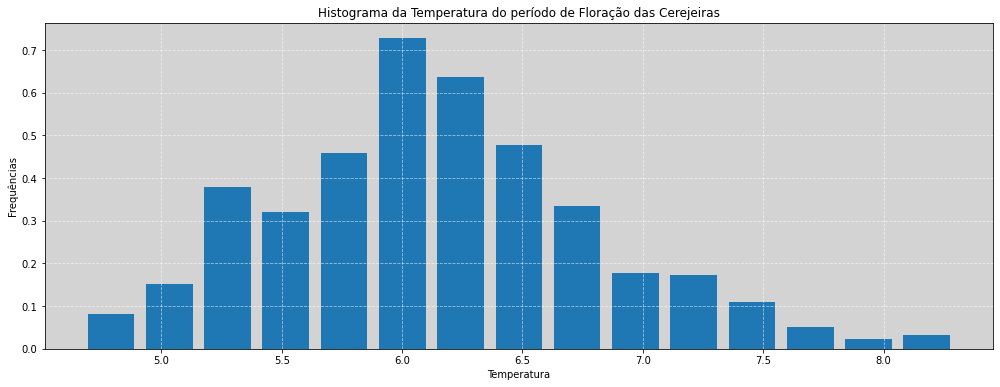

In [38]:
plt.figure(figsize=(17, 6))
plt.hist(cherry_df.temp, bins=15, rwidth=0.8, density=True)
plt.grid(ls='--', color='white', alpha=0.6)

plt.title('Histograma da Temperatura do período de Floração das Cerejeiras')
plt.xlabel('Temperatura')
plt.ylabel('Frequências')
plt.show()

Com as splines definidas acima, iremos construir nosso modelo em *Stan* para estimar a temperatura em cada ano da floração das cerejeiras. Iremos supor que a temperatura é distribuída normalmente, conforme gráfico acima.

O modelo matemático será descrito como:

$$ temperatura \sim normal(\mu, \sigma) $$

no qual a média, $\mu$, será construída da seguinte forma:

$$ \mu = \alpha + w_1  B_{i, 1} + w_2  B_{i, 2} + w_3  B_{i, 3} + w_4  B_{i, 4} +  w_5  B_{i, 5}$$

Para evitar de termos que escrever todos os termos na mão dentro da *stan*, podemos reescrever a equação acima da seguinte forma:

$$ \mu = \alpha + w_k  B_{i, k} $$

Essa notação matemática converte a equação acima para uma simples multiplicação de matrizes, conforme vimos no ensino médio, e assim, tanto evitamos reescrever todos os termos manualmente quanto conseguirmos otimizar os custos computacionais envolvidos nos cálculos. (*Geralmente é sempre uma boa ideia utilizar matrizes.*)

In [39]:
# ==================================
#   Construindo o modelo b-spline
# ==================================

model_spline_1 = """
    data {
        int<lower=0> N;  // Número de observações
        int<lower=0> K;  // Número de Knots
        matrix[N, K] B;  // B-splines
        vector[N] temp;  // Variável resposta (y)
    }

    parameters {
        real<lower=0> sigma;
        real alpha;
        vector[K] w;  // Pesos
    }

    model {
        alpha ~ normal(100, 10);  // Priori para alpha
        w ~ normal(0, 1);         // Priori para w
        sigma ~ exponential(1);   // Priori para sigma
        
        temp ~ normal(alpha + B * w, sigma);  // Verossimilhanças (Likelohood)
    }
"""

N = np.shape(spline_1)[0]  # Número de amostras
K = np.shape(spline_1)[1]  # Número de nós (knots)

dados = {
    'N': N,
    'K': K,
    'B': np.matrix(spline_1),
    'temp': cherry_df.temp.fillna(cherry_df.temp.mean()).values,  # Colocando os valores NA como média da série.
}

posteriori_spline_1 = stan.build(model_spline_1, data=dados)
fit_spline_1 = posteriori_spline_1.sample(num_chains=4, num_samples=1000)

alpha_spline_1 = fit_spline_1['alpha']
w_spline_1 = fit_spline_1['w']
sigma_spline_1 = fit_spline_1['sigma'].flatten()

Bw_spline_1 = np.matmul(spline_1, w_spline_1)  # Fazendo a multiplicação das matrizes B * w 

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_by2s3ozq/model_zq2l6lwo.stan', line 16, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  46% (3700/8000)
Sampling:  64% (5100/8000)
Sampling:  80% (6400/8000)
Sampling:  96% (7700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog st

Com o modelo ajustado, temos a estimativa do parâmetro $w$, que são os pesos de cada uma das funções de base. Para sabermos qual o efeito gerado de cada um desses pesos, iremos aplicá-los nas funções, multiplicamos ambos:

$$ \mbox{Bw_spline_1} = w_k B_{1, k} $$

O resultado dessa operação pode ser visto no gráfico abaixo.

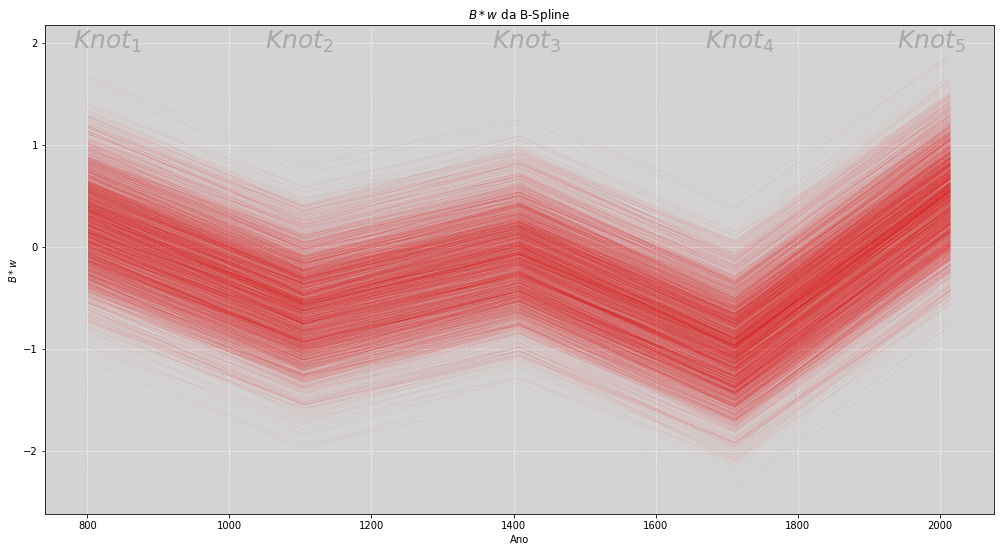

In [40]:
# ====================================================
#    Plot da Posteriori do Mu da B-Spline de Grau 1
# ====================================================
plt.figure(figsize=(17, 9))

plt.plot(cherry_df.year,  Bw_spline_1,  # Plot do B * w
         color='red', linewidth=0.2, alpha=0.1) 
 
plt.title('$B*w$ da B-Spline')
plt.xlabel('Ano')
plt.ylabel('$B*w$')
plt.grid(ls='--', color='white', alpha=0.6)

plt.text(780, 1.95,'$Knot_1$', size=25, color='darkgray')
plt.text(1050, 1.95,'$Knot_2$', size=25, color='darkgray')
plt.text(1370, 1.95,'$Knot_3$', size=25, color='darkgray')
plt.text(1670, 1.95,'$Knot_4$', size=25, color='darkgray')
plt.text(1940, 1.95,'$Knot_5$', size=25, color='darkgray')

plt.show()

Para conseguirmos verificar a estimativa da temperatura de modo visual, somaremos, ao valor de `Bw_spline_1` o valor `alpha_spline_1`, que é a estimativa do valor médio da temperatura. Veja a seguir o gráfico. 

Assim como em outros modelos anteriores, temos a região de plausibilidade dada pelas retas em cada um dos nós. Apesar de termos apenas $5$ nós, a estimativa para $\mu$ é muito boa.

Para termos uma estimativa mais detalhada, `devemos aumentar o número de nós e também alterar o grau das funções de bases usadas`. Quando maior o número de nós e, também, maior o número do grau das funções de base, tendemos a ter um ajuste mais preciso.

Um ajuste preciso pode ser preocupante e estragar nosso dia., O motivo disso é um efeito conhecido como `overffiting`. Iremos tratar disso mais adiante, mas de modo geral *overffting*, ou sobreajuste, é a capacidade do modelo identificar detalhes minuciosos na amostra, mas não conseguir ser bom em identificar os detalhes na população. 

<img src="./images/overffiting.jpg" alt="overffiting example" width=500>

Por enquanto, iremos apenas entender como é o funcionamento de uma spline e, em capítulos posteriores, veremos mais detalhes sobre o fantasma do `overffiting` em nossos modelos.

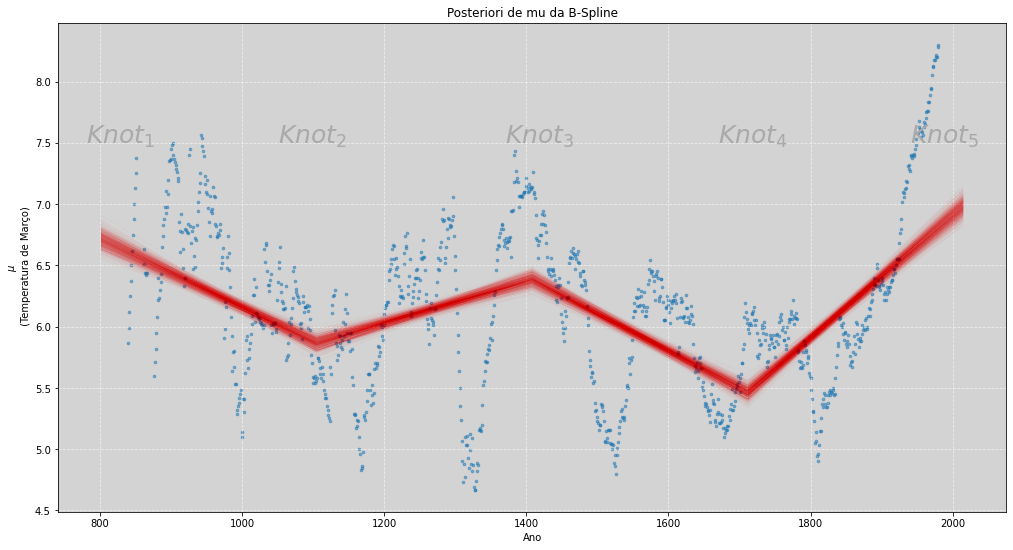

In [41]:
# ======================================================
#    Plot da Posteriori de mu da B-Spline de Grau 1
# ======================================================
plt.figure(figsize=(17, 9))

n_plot = 1000  # Define a quantidade de simulações para o plot

plt.scatter(cherry_df.year, cherry_df.temp, marker='o', alpha=0.5, s=7)  # Plot da amostra
plt.plot(cherry_df.year, alpha_spline_1[:, :n_plot] + Bw_spline_1[:, :n_plot],  # mu
         color='red', linewidth=0.1, alpha=0.1) 
 
plt.title('Posteriori de mu da B-Spline')
plt.xlabel('Ano')
plt.ylabel('$\mu$ \n (Temperatura de Março)')
plt.grid(ls='--', color='white', alpha=0.6)

plt.text(780,  7.5,'$Knot_1$', size=25, color='darkgray')
plt.text(1050, 7.5,'$Knot_2$', size=25, color='darkgray')
plt.text(1370, 7.5,'$Knot_3$', size=25, color='darkgray')
plt.text(1670, 7.5,'$Knot_4$', size=25, color='darkgray')
plt.text(1940, 7.5,'$Knot_5$', size=25, color='darkgray')

plt.show()

In [42]:
# ==========================================================
#      Reamostragem da Posteriori B-Spline de Grau 1 
# ==========================================================

posteriori_spline_1 = np.random.normal(alpha_spline_1 + Bw_spline_1, sigma_spline_1)  # Amostras normal(mu, sigma)

intervalo_credibilidade = 0.96  # Intervalo de credibilidade - HPDI

HPDI_posteriori_spline_1 = [] # Vetor do HPDI

for year_i in range(np.shape(posteriori_spline_1)[0]):  # OBS: Essa operação é um pouco demorada. 
    HPDI_posteriori_spline_1.append(HPDI(posteriori_spline_1[year_i, :], intervalo_credibilidade))

HPDI_posteriori_spline_1 = np.array(HPDI_posteriori_spline_1)
mean_posteriori_spline_1 = posteriori_spline_1.mean(axis=1)  # Média do HPDI por cada ano

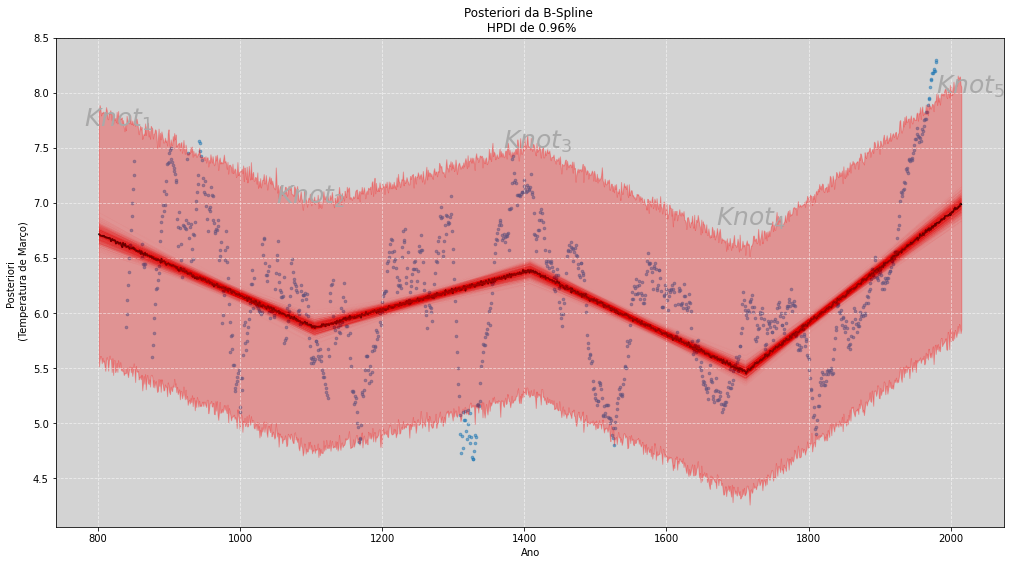

In [43]:
# ===============================================
#    Plot da Posteriori da B-Spline de Grau 1
# ===============================================
plt.figure(figsize=(17, 9))

plt.scatter(cherry_df.year, cherry_df.temp, marker='o', alpha=0.5, s=7)  # Plot da amostra

plt.fill_between(cherry_df.year, HPDI_posteriori_spline_1[:, 0], HPDI_posteriori_spline_1[:, 1],  # Plot HPDI
         color='red', alpha=0.3, label='HPDI da Posteriori') 

plt.plot(cherry_df.year, mean_posteriori_spline_1, color='black', label='Média da posteriori')  # Plot da Média

plt.plot(cherry_df.year, alpha_spline_1[:, :n_plot] + Bw_spline_1[:, :n_plot],  # Plot do Intevalo da Média (Sem o HPDI)
         color='red', linewidth=0.1, alpha=0.1) 

plt.title('Posteriori da B-Spline \n HPDI de ' + str(intervalo_credibilidade) + '%')
plt.xlabel('Ano')
plt.ylabel('Posteriori \n (Temperatura de Março)')
plt.grid(ls='--', color='white', alpha=0.6)

plt.text(780,  7.7,'$Knot_1$', size=25, color='darkgray')
plt.text(1050, 7.0,'$Knot_2$', size=25, color='darkgray')
plt.text(1370, 7.5,'$Knot_3$', size=25, color='darkgray')
plt.text(1670, 6.8,'$Knot_4$', size=25, color='darkgray')
plt.text(1980, 8.0,'$Knot_5$', size=25, color='darkgray')

plt.show()

Agora que entendemos como é a construção de uma spline e como ajustar elas aos dados, iremos construir as mesmas estimativas usando as splines que mais são usadas nos dia a dia. A capacidade de inferência de uma spline com grau maior que o utilizado no exemplo anterior e, tambéme a adição de mais pontos ao longo do eixo $x$ permite um ajuste muito melhor que aquele que fizemos no exemplo anterior. 

A seguir a descrição e a construção uma `spline` com grau 3 e 15 nós ao longo do eixo.

In [44]:
from scipy.interpolate import BSpline

In [45]:
cherry_not_na = cherry_df[cherry_df.doy.notna()]  # Removendo os NA's do DOY

In [46]:
# ======================================
#    Construindo a BSpline - Ordem 3
# ======================================

qty_knots = 15
knot_quantile = np.quantile(cherry_not_na.year, np.linspace(0, 1, qty_knots))
knots_adjusts = np.pad(knot_quantile, (3, 3), mode='edge')
knots_B = BSpline(knots_adjusts, np.identity(qty_knots + 2), k=3)(cherry_not_na.year.values)

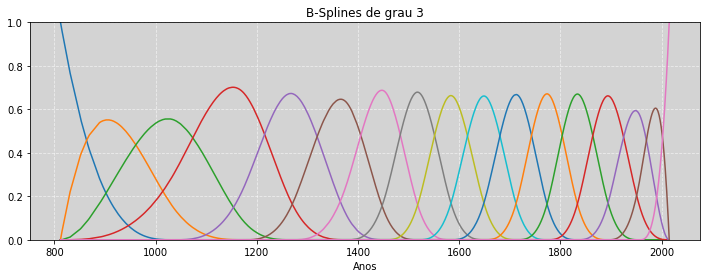

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for i in range(np.shape(knots_B)[1]):
    ax.plot(cherry_not_na.year, knots_B[:, i])
    
plt.title('B-Splines de grau 3')
plt.xlabel('Anos')
plt.grid(ls='--', color='white', alpha=0.6)
plt.ylim((0, 1))
plt.show()

In [48]:
# =======================================================
#   Construindo o modelo b-spline de grau 3 com 15 nós
# =======================================================

# Perceba que o modelo de grau 3 terá a mesma estrutura do modelo de grau 1 
model_spline_3 = """
    data {
        int<lower=0> N;  // Número de observações
        int<lower=0> K;  // Número de Knots
        matrix[N, K] B;  // B-splines
        vector[N] temp;  // Variável resposta (y)
    }

    parameters {
        real<lower=0> sigma;
        real alpha;
        vector[K] w;  // Pesos
    }

    model {
        alpha ~ normal(100, 10);  // Priori para alpha
        w ~ normal(0, 1);         // Priori para w
        sigma ~ exponential(1);   // Priori para sigma
        
        temp ~ normal(alpha + B * w, sigma);  // Verossimilhanças (Likelohood)
    }
"""

N = np.shape(knots_B)[0]  # Número de amostras
K = np.shape(knots_B)[1]  # Número de nós (knots)

dados = {
    'N': N,
    'K': K,
    'B': np.matrix(knots_B),
    'temp': cherry_not_na.temp.fillna(cherry_not_na.temp.mean()).values,  # Colocando os valores NA como média da série.
}

posteriori_spline_3 = stan.build(model_spline_3, data=dados)
fit_spline_3 = posteriori_spline_3.sample(num_chains=4, num_samples=1000)

alpha_spline_3 = fit_spline_3['alpha'].flatten()
w_spline_3 = fit_spline_3['w']
sigma_spline_3 = fit_spline_3['sigma'].flatten()

# Fazendo a multiplicação das matrizes B * w
Bw_spline_3 = np.matmul(np.matrix(knots_B), w_spline_3)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_by2s3ozq/model_zq2l6lwo.stan', line 16, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  55% (4400/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.3e-05 seconds
  1000 transi

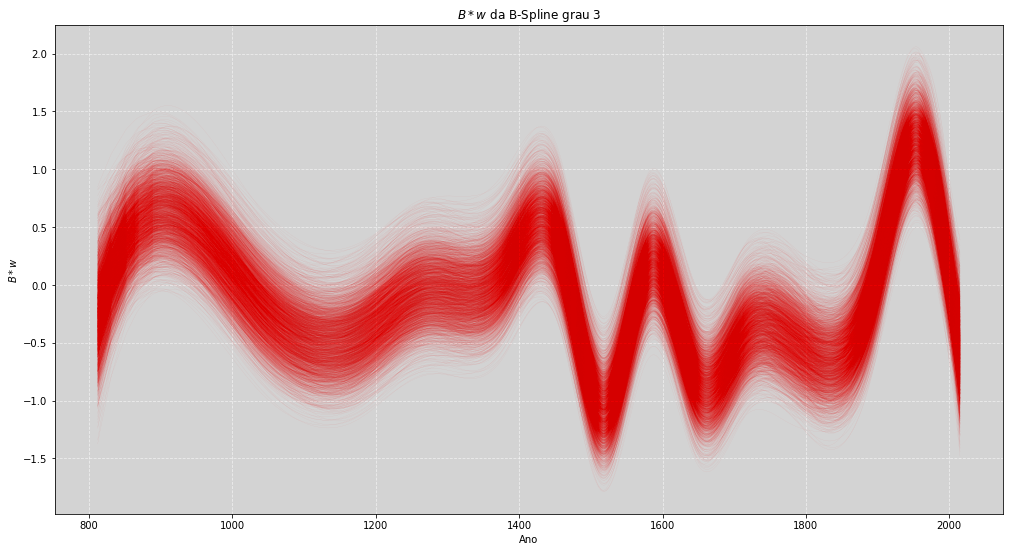

In [49]:
# ====================================================
#    Plot da Posteriori do Mu da B-Spline de Grau 3
# ====================================================
plt.figure(figsize=(17, 9))

plt.plot(cherry_not_na.year,  Bw_spline_3,  # Plot do B * w
         color='red', linewidth=0.2, alpha=0.1) 
 
plt.title('$B*w$ da B-Spline grau 3')
plt.xlabel('Ano')
plt.ylabel('$B*w$')
plt.grid(ls='--', color='white', alpha=0.6)

plt.show()

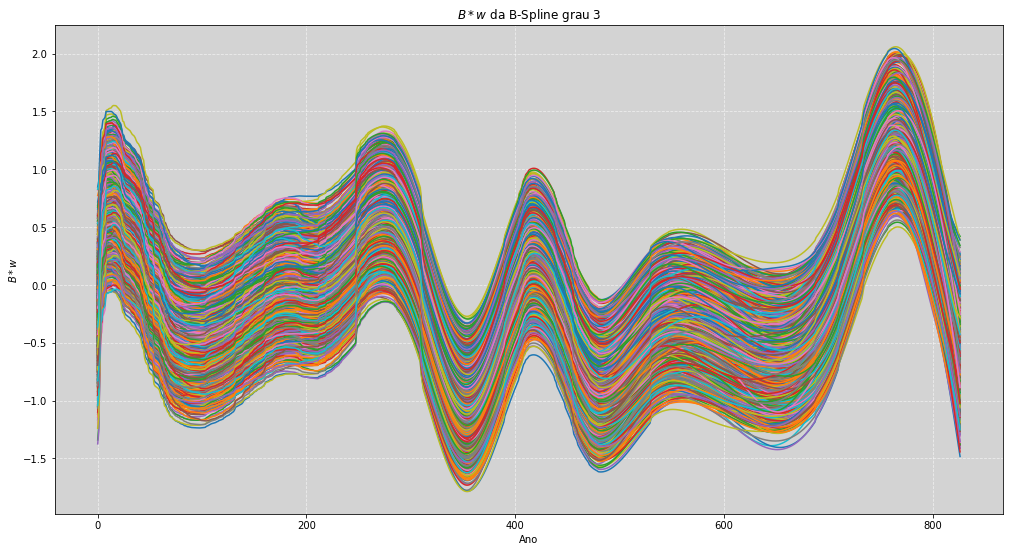

In [54]:
plt.figure(figsize=(17, 9))
plt.plot(Bw_spline_3)

plt.title('$B*w$ da B-Spline grau 3')
plt.xlabel('Ano')
plt.ylabel('$B*w$')
plt.grid(ls='--', color='white', alpha=0.6)

plt.show()

In [55]:
# ==========================================================
#      Reamostragem da Posteriori B-Spline de Grau 3 
# ==========================================================

posteriori_spline_3 = np.random.normal(alpha_spline_3 + Bw_spline_3, sigma_spline_3)  # Amostras normal(mu, sigma)

# Intervalo de credibilidade - HPDI
#  Lembre-se: a velocidade do cálculo do HPDI é tão mais rápido quando 
#             mais próximo de 1 estiver o valor do intervalo_credibilidade
#  Altere esses valores para perceber a abertura do intevalo de credibilidade sobre os dados.
intervalo_credibilidade = 0.97

HPDI_posteriori_spline_3 = [] # Vetor do HPDI

for year_i in range(np.shape(posteriori_spline_3)[0]):  # XXX: Essa operação é um pouco demorada. 
    HPDI_posteriori_spline_3.append(HPDI(posteriori_spline_3[year_i, :], intervalo_credibilidade))

HPDI_posteriori_spline_3 = np.array(HPDI_posteriori_spline_3)
mean_posteriori_spline_3 = posteriori_spline_3.mean(axis=1)  # Média do HPDI por cada ano

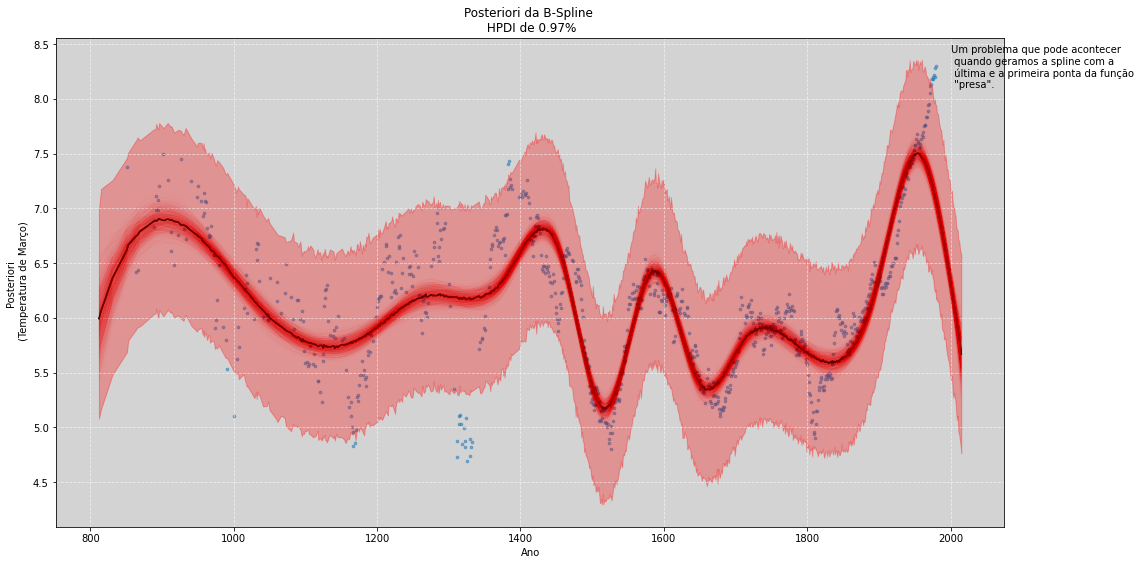

In [56]:
# ===============================================
#    Plot da Posteriori da B-Spline de Grau 3
# ===============================================
plt.figure(figsize=(17, 9))

plt.scatter(cherry_not_na.year, cherry_not_na.temp, marker='o', alpha=0.5, s=7)  # Plot da amostra

plt.fill_between(cherry_not_na.year, HPDI_posteriori_spline_3[:, 0], HPDI_posteriori_spline_3[:, 1],  # Plot HPDI
         color='red', alpha=0.3, label='HPDI da Posteriori') 

plt.plot(cherry_not_na.year, mean_posteriori_spline_3, color='black', label='Média da posteriori')  # Plot da Média

# Plot do Intevalo da Média (Sem o HPDI)
plt.plot(cherry_not_na.year, alpha_spline_3[:n_plot] + Bw_spline_3[:, :n_plot], color='red', linewidth=0.1, alpha=0.1) 

plt.title('Posteriori da B-Spline \n HPDI de ' + str(intervalo_credibilidade) + '%')
plt.xlabel('Ano')
plt.ylabel('Posteriori \n (Temperatura de Março)')
plt.grid(ls='--', color='white', alpha=0.6)

plt.text(2000, 8.1, 'Um problema que pode acontecer \n quando geramos a spline com a \n última e a primeira ponta da função \n "presa".')

plt.show()

## Possibilidades das Splines

- A quantidade de nós e os graus das funções de base são de nossa escolha.

Exitem muitas maneiras diferente de se definir uma *spline*, assim como existem muitos outros tipos de *splines*. As que vimos aqui foram as splines mais simples. 

Obs: No curso a definição das b-splines são um pouco diferente das que usamos aqui. Para saber com é o formato das funções que o Richard usa ver a aula [Statistical Rethinking Winter 2019 Lecture 04](https://www.youtube.com/watch?v=ENxTrFf9a7c&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI) a partir dos 57 minutos.



- Devemos nos preocupar com o overfitting dos dados (Veremos isso no capíputo 7).


- Outros tipos de splines não precisam de nós (*knots*)

- Uma outra ideia de aproximação que veremos no capítulo 14 será as ideias dos `Processos Gaussianos`.

- Todas as splines são descritivas e não mecanicista.
